# 0.0. Imports

In [1]:
import warnings
from tabulate import tabulate
import psycopg2 as pg
import numpy  as np
import pandas as pd
import boruta as bt
import scikitplot as skplt
import pickle
from IPython.core.display  import HTML
import seaborn as sns

import pandas.io.sql as psql
import os
from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D
import optuna
from imblearn.combine      import SMOTETomek
from IPython.core.display import Image
from scipy                import stats           as ss
from matplotlib import pyplot as plt
import xgboost           as xgb
from sklearn.ensemble     import RandomForestRegressor
from sklearn.ensemble     import RandomForestClassifier
from sklearn.ensemble     import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from boruta               import BorutaPy
from sklearn.naive_bayes  import GaussianNB
from sklearn.neighbors    import KNeighborsClassifier
from sklearn              import svm
from sklearn             import base
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from lightgbm             import LGBMClassifier
from pandas_profiling     import ProfileReport
from sklearn.model_selection import StratifiedKFold
from   sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn import preprocessing   as pp
from sklearn import linear_model    as lm
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import metrics         as m

In [2]:
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

# 0.1. Helper Function

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    show

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr=k - (k-1)**2/(n-1) 
    rcorr=r - (r-1)**2/(n-1) 
    
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1)))
    return v

def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict



def cross_validation(model, x_train, y_train, k, data, Verbose = True):
    
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    recall_list = []
    precision_k_list = []
    recall_k_list = []
    accuracy_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        
        if Verbose == True:
            
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)
        
        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:, 1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k = 20000)
        precision_k_list.append(precision_k,)
        
        recall_k = recall_at_k(data, k = 20000)
        recall_k_list.append(recall_k)
        
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)

        accuracy = accuracy_score(y_val_fold, yhat_1)
        accuracy_list.append(accuracy)
            
        
        i+=1
        
    df = pd.DataFrame({'Model Name': type(model).__name__, 
                       'Accuracy Mean': np.mean(accuracy_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Recall Mean': np.mean(recall_list).round(4),
                       'Recall STD': np.std(recall_list).round(4),
                       'Precision@K Mean': np.mean(precision_k_list).round(4), 
                       'Precision@K STD': np.std(precision_k_list).round(4),
                       'Recall@K Mean': np.mean(recall_k_list).round(4), 
                       'Recall@K STD': np.std(recall_k_list).round(4)}, index = [0])

    return df

def precision_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']



def recall_at_k( data, k = 20000 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


class KFoldTargetEncoder(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        
    def fit(self, X, y=None):
        
        return self
    
    
    def transform(self,X):
    
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2021)
        print(kf)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            
            #train set and validation set
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            
            #test set you take the average of the target values of all samples that have a given category in the entire train set.
            X[col_mean_name].fillna(mean_of_target, inplace = True)
            
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            
        return X

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2. Load dataset

In [5]:
# Credenciais do Banco de dados Postgress
param_dict={
    'USER': os.getenv('USER_CDS'),
    'HOST': os.getenv('HOST_CDS'),
    'PORT': os.getenv('PORT_NUM'),
    'DATABASE': os.getenv('DATABASE_CDS'),
    'PWD': os.getenv('PWD_CDS')
}

# Acessando os dados com SQL

conn = pg.connect(user=param_dict['USER'],
                  password= param_dict['PWD'],
                  host=param_dict['HOST'],
                  port=param_dict['PORT'],
                  database=param_dict['DATABASE'])

#SELECT nspname
#FROM pg_catalog.pg_namespace pn 

#select tablename
#from pg_catalog.pg_tables
#where schemaname = 'pa004

query ='''
SELECT *
FROM pa004.users u inner join pa004.vehicle v on (u.id=v.id)
                   inner join pa004.insurance i on (u.id = i.id)
'''
df_raw=psql.read_sql(query, conn)
#df_raw= df_raw.drop(df_raw.columns[[5,9]], axis=1)
conn.close()



# 1.0. Data Description

In [18]:
df_aux= df_raw.copy
df1 = df_raw.copy()

df1= df1.drop(df1.columns[[5]], axis=1)
df1['id']=df_raw.iloc[:,0]


## 1.1. Rename Columns

In [19]:
df1 = df1[['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']]



## 1.2 Split Data into Training/validation and Test data set

In [20]:
split_data = np.random.rand(len(df1)) < 0.80
train_data = df1[split_data]
future_test = df1[~split_data]

df1=train_data.copy()

## 1.3 Data Dimensions

In [21]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 305057
Number of Cols: 12


## 1.4 Data Types

In [22]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.5 Check Data

### 1.5.1 Check NA

In [23]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 1.5.2 Check Balanced Data

In [24]:
df1['response'].value_counts(normalize=True)

0    0.877459
1    0.122541
Name: response, dtype: float64

## 1.6 Data Descriptive

In [25]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numerical Attributes

In [26]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190611.210423,190721.0,110033.816708,-0.000967,-1.199787
1,age,20.0,85.0,65.0,38.838299,36.0,15.506788,0.671087,-0.567671
2,driving_license,0.0,1.0,1.0,0.997886,1.0,0.045934,-21.678638,467.966398
3,region_code,0.0,52.0,52.0,26.398591,28.0,13.225435,-0.113816,-0.868695
4,previously_insured,0.0,1.0,1.0,0.457796,0.0,0.498216,0.169420,-1.971310
5,annual_premium,2630.0,540165.0,537535.0,30557.884297,31661.0,17239.666346,1.774598,33.983513
6,policy_sales_channel,1.0,163.0,162.0,111.941309,131.0,54.246365,-0.896037,-0.978628
7,vintage,10.0,299.0,289.0,154.266740,154.0,83.697166,0.003383,-1.201350
8,response,0.0,1.0,1.0,0.122541,0.0,0.327910,2.302225,3.300260


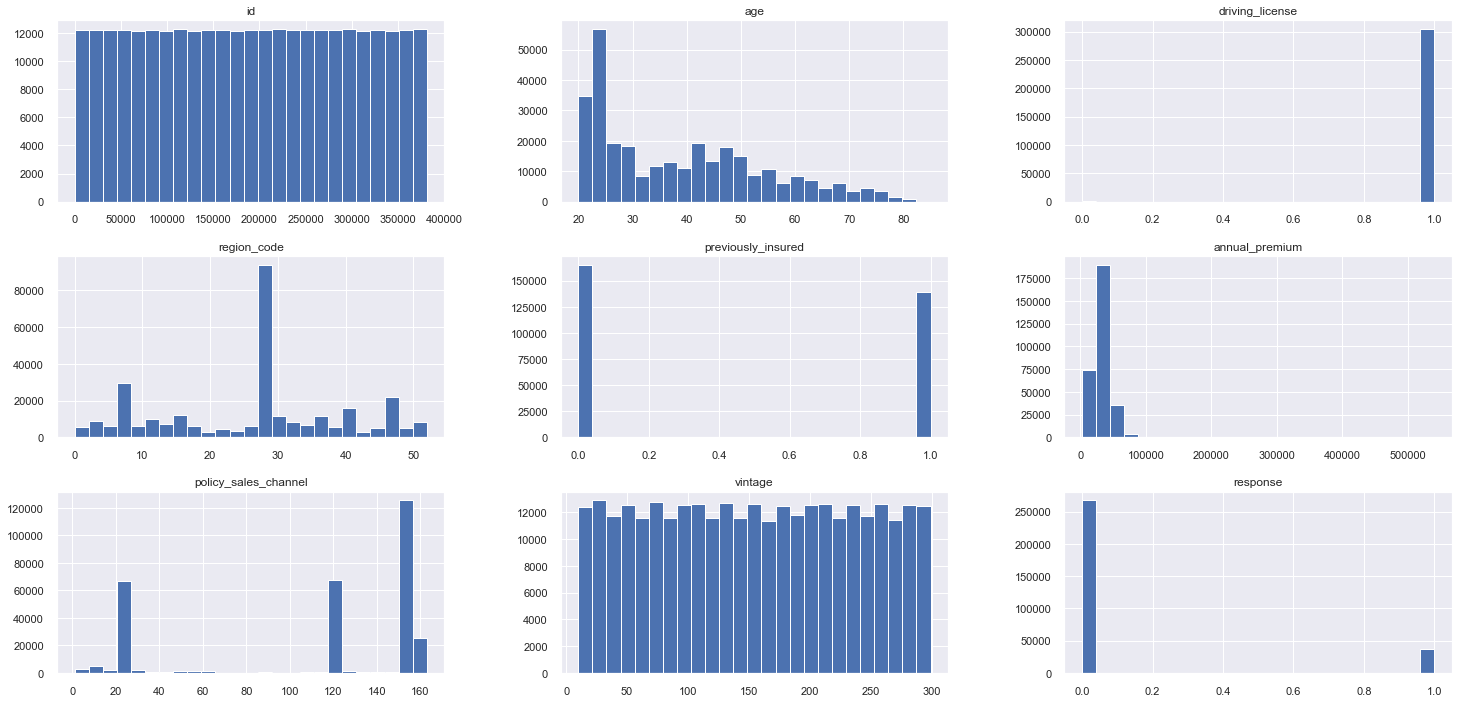

In [27]:
num_attributes.hist(bins=25);

### 1.6.2 Categorical Attributes

In [28]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,305057,305057,305057
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164931,160430,154117


# 2.0. Feature Engineering

In [29]:
df2 = df1.copy()

## 2.1 Hypotheses Mindmap

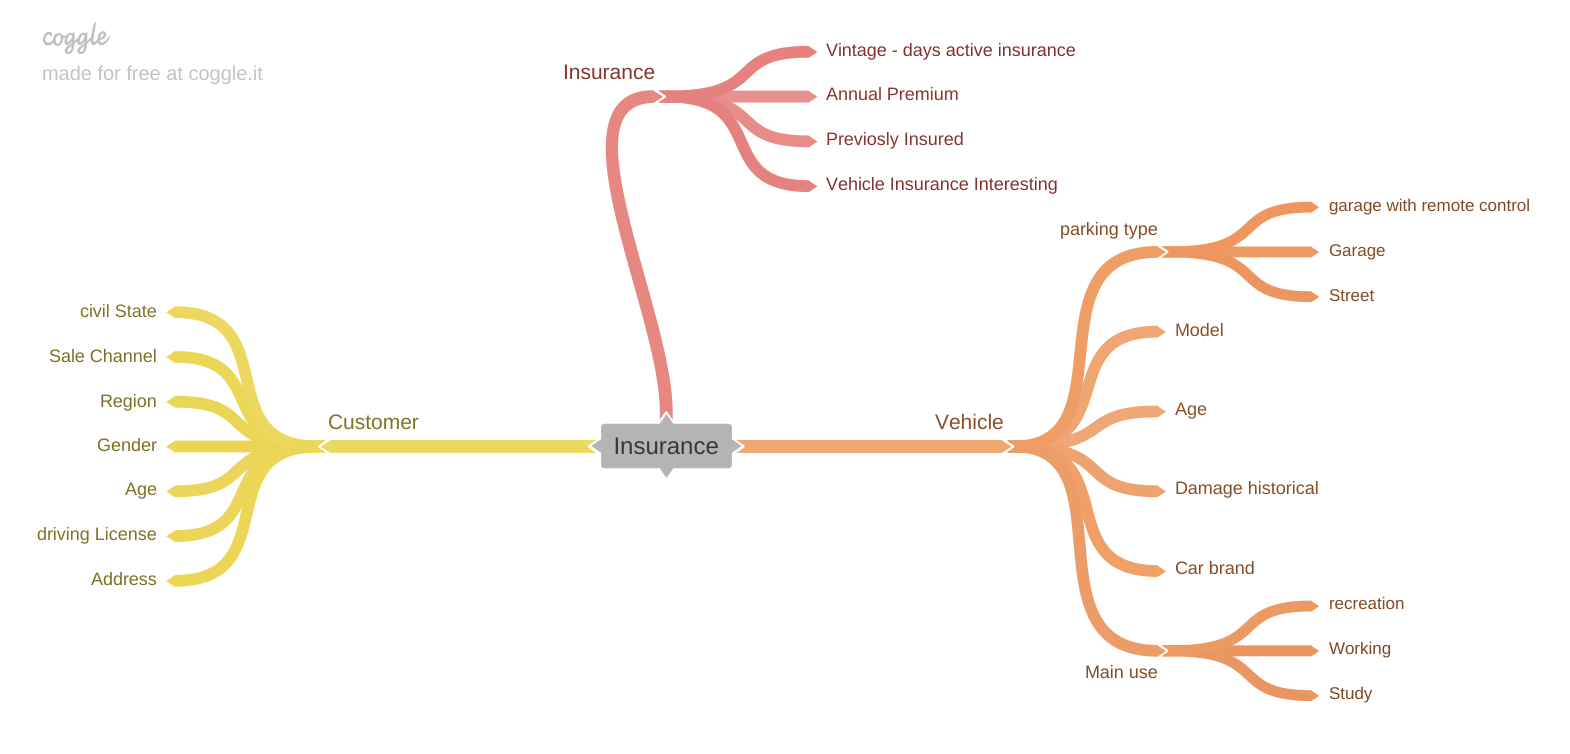

In [150]:
Image('/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/images/MindMap.png')

## 2.1.2 Hypothesis

 **H1 -** Mulheres tem mais interesse em comprar seguro de veículos que homens.
 
 **H2 -** Clientes com carros novos/seminovos (menor que 2 anos), tem mais interesse em seguro de veículos.
 
 **H3 -** Clientes sem carteira de motorista não tem interesse algum em seguro de veículos.
 
 **H4 -** Clientes que ja sofreram algum acidente tem mais interesse em adquirir seguro de veículos.
 
 **H5 -** Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos. 
 
 **H6 -** Clientes que pagaram entre 30000 e 40000 para serem premium no ano(Annual Premium) tem mais interesse em adquirir seguro de veículos.
 
 **H7 -** Homens tem mais eventos de dano a veículos, do que mulheres. 

## 2.1.3 Feature Engineering

In [30]:
# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# 3.0. Data Filtering

In [31]:
df3=df2.copy()

# 4.0. Exploratory Data Analysis

In [19]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response Variable

/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


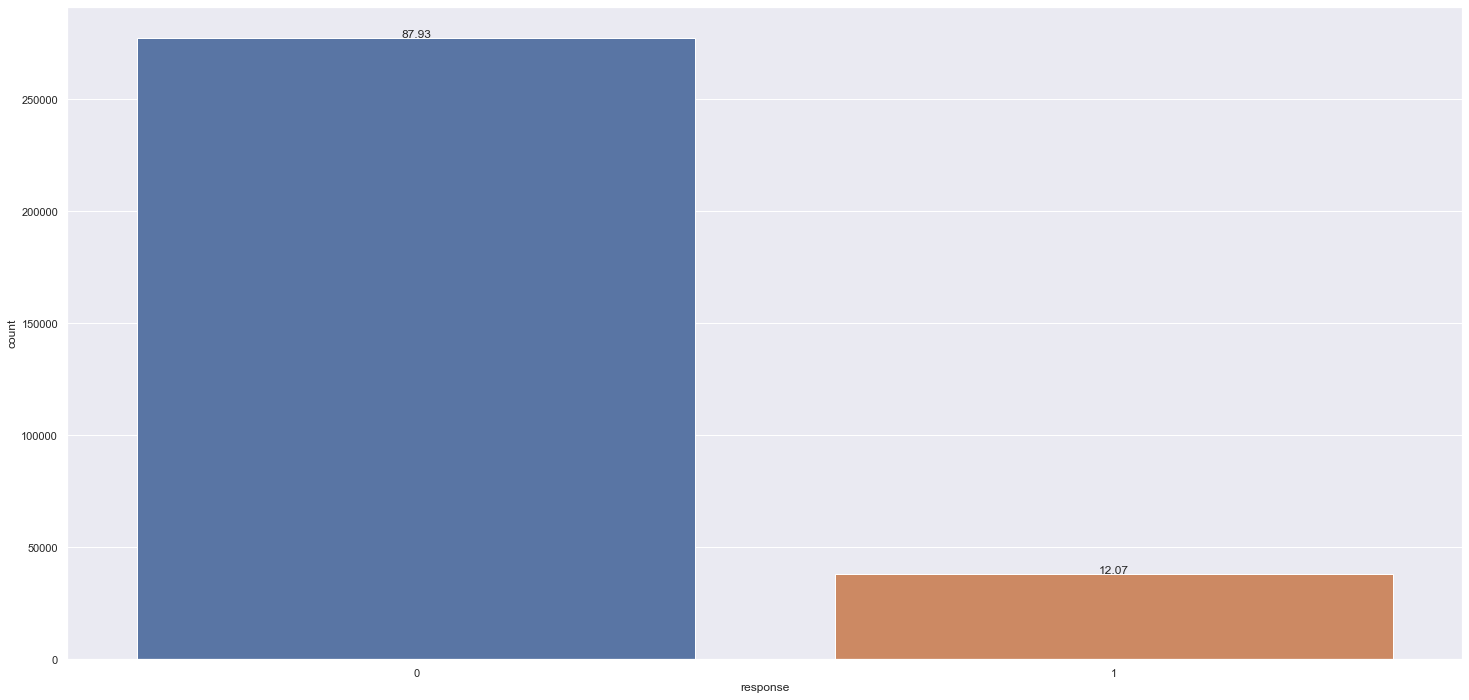

In [67]:
ax=sns.countplot(df4['response'])
total=len(df4['response'])
graphic_percentage(ax,total)

### 4.1.2. Age

<AxesSubplot:xlabel='response', ylabel='age'>

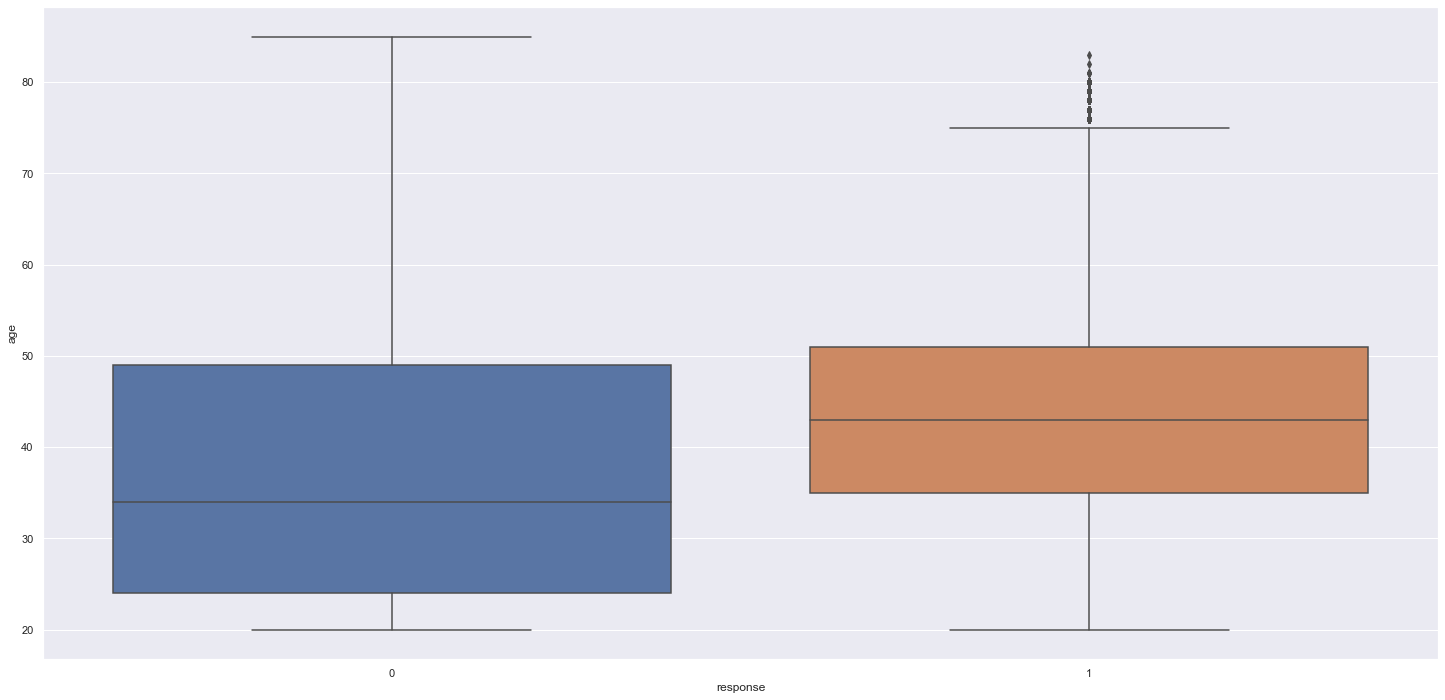

In [32]:
sns.boxplot( x='response', y='age', data=df4 )

<AxesSubplot:xlabel='age', ylabel='Count'>

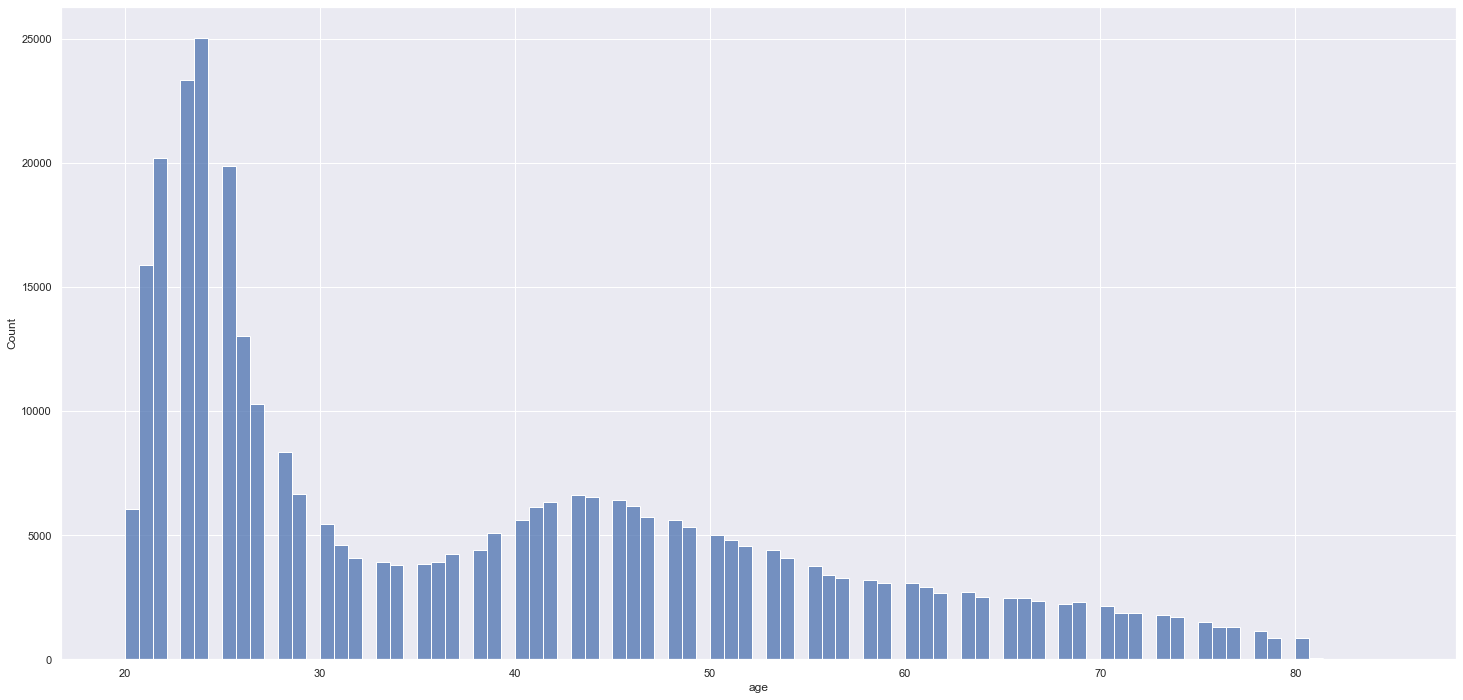

In [33]:
# Histograma de idade para respostas negativas
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='age', ylabel='Count'>

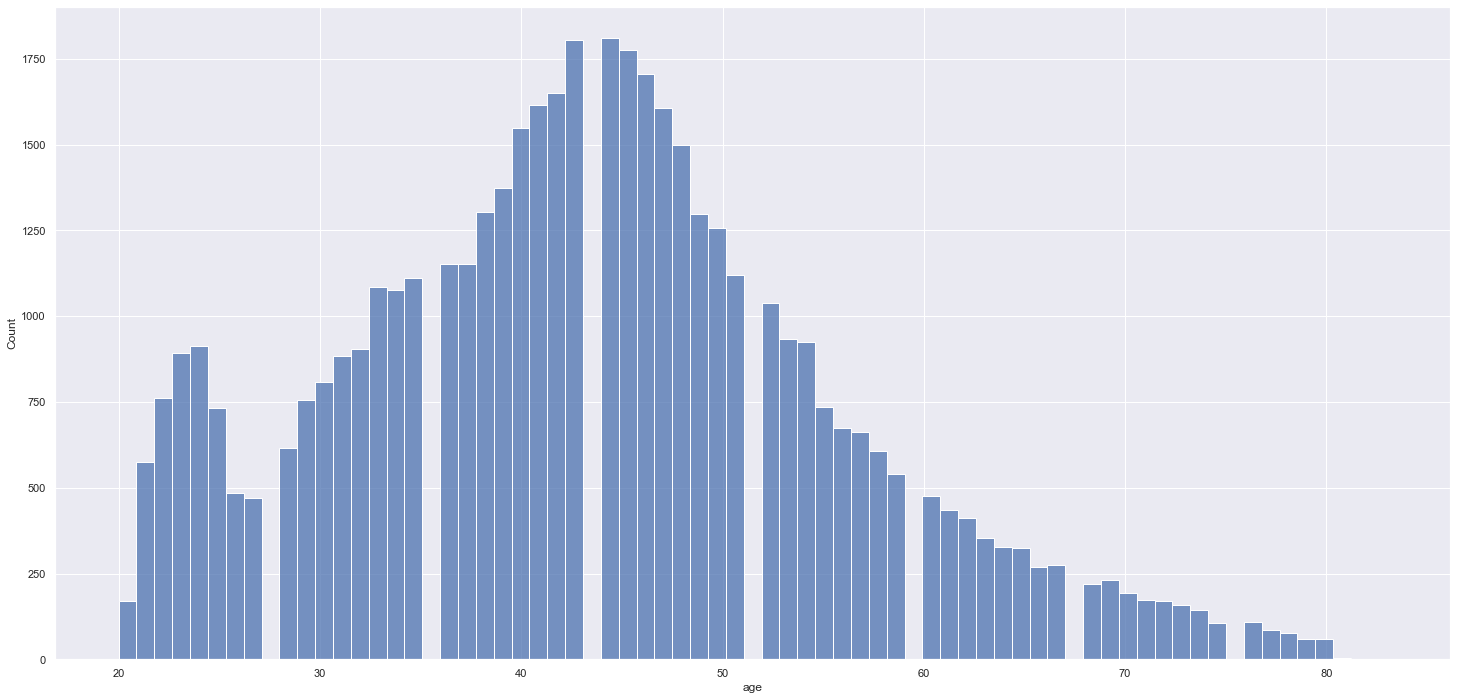

In [34]:
# Histograma de idade para respostas positivas
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

### 4.1.3. Anual Income

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

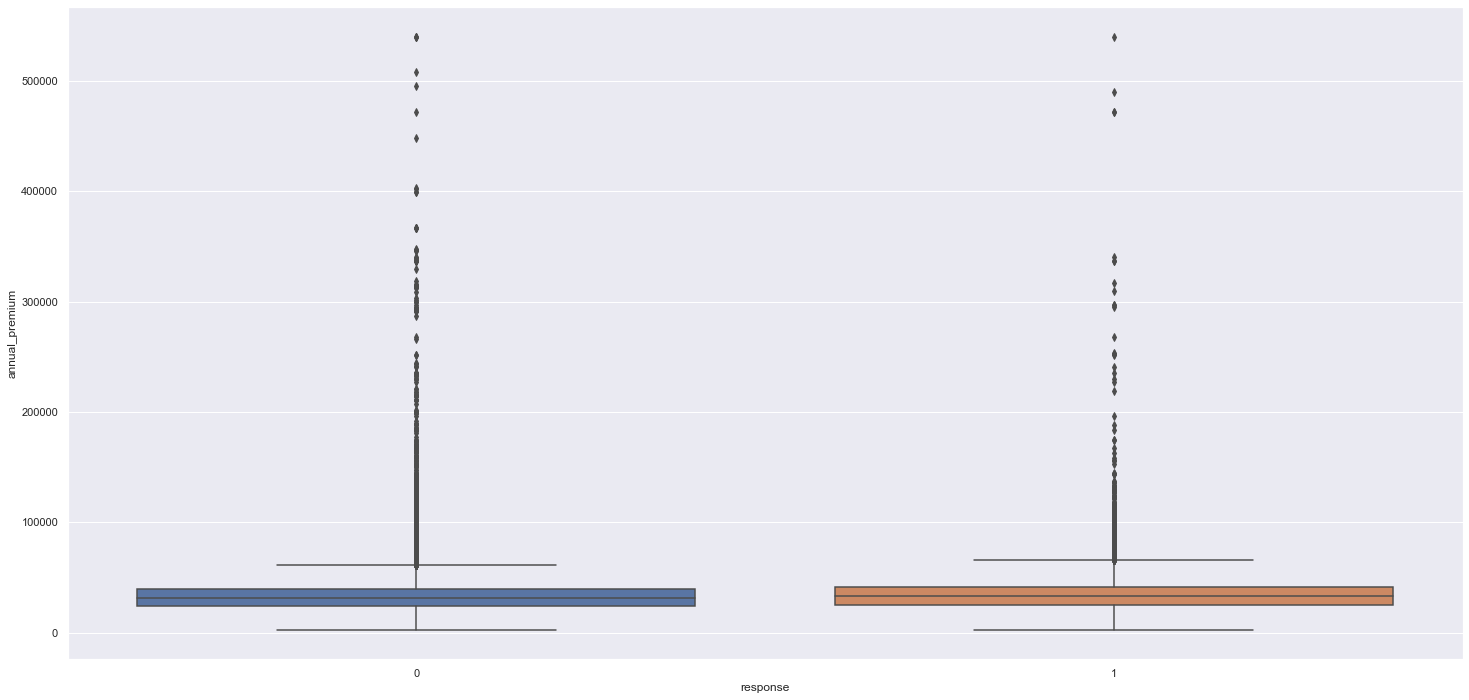

In [35]:
sns.boxplot( x='response', y='annual_premium', data=df4 )

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

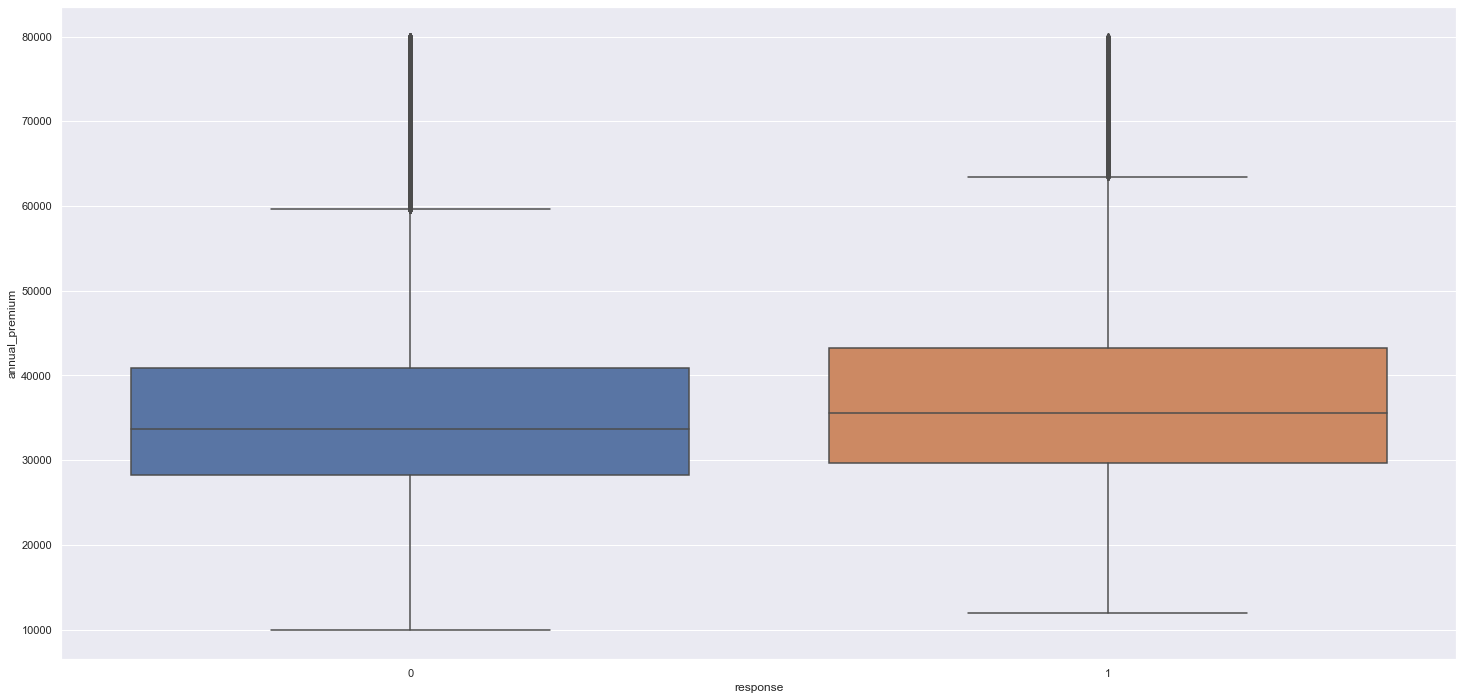

In [52]:
# Fora da margem de outliers
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux )

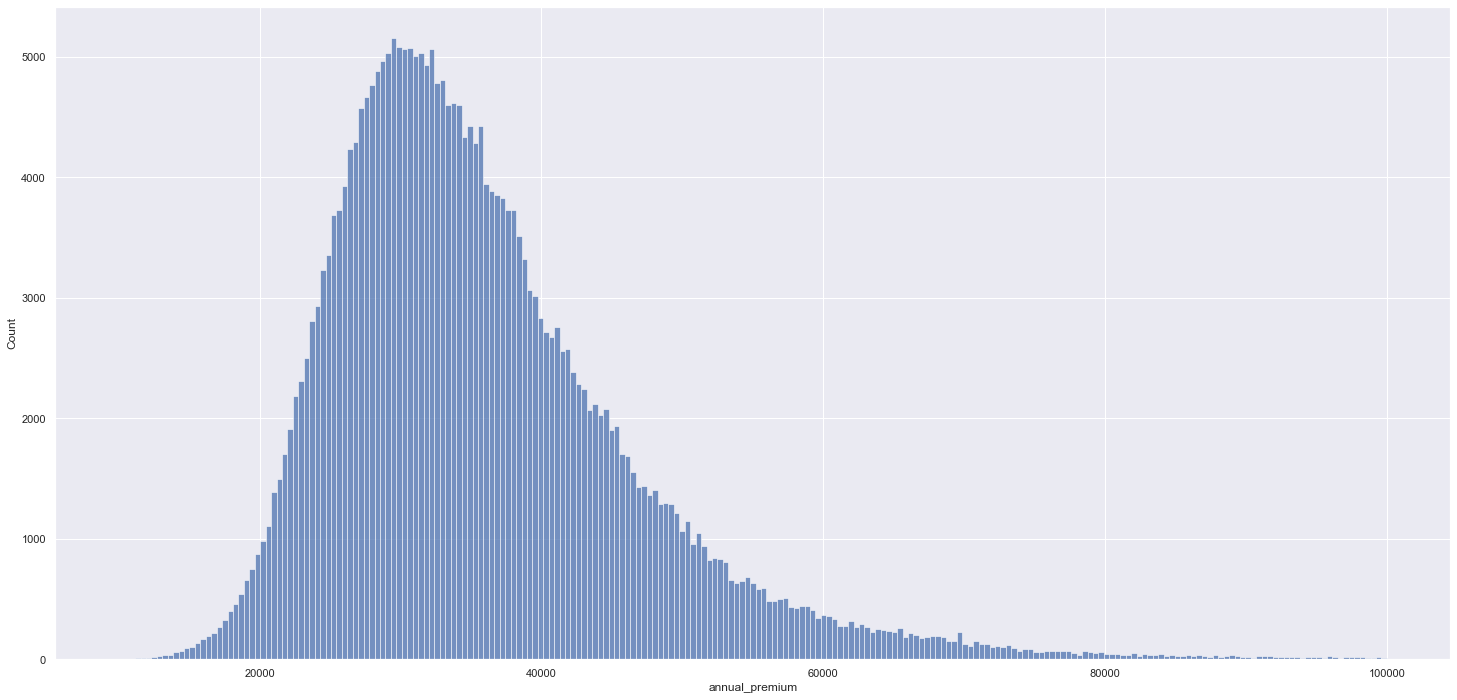

In [51]:
# Histograma para respostas negativas
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

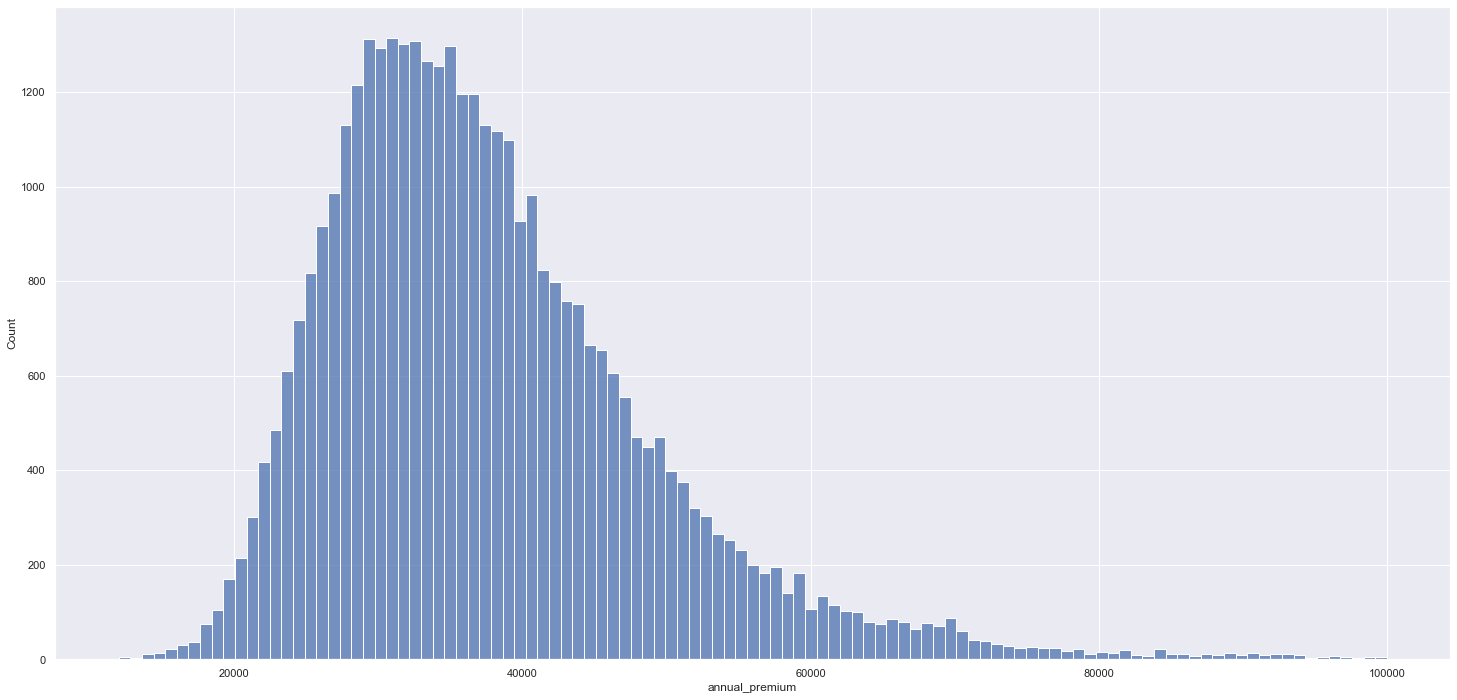

In [53]:
# Histograma para respostas positivas
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

### 4.1.4. Driving License

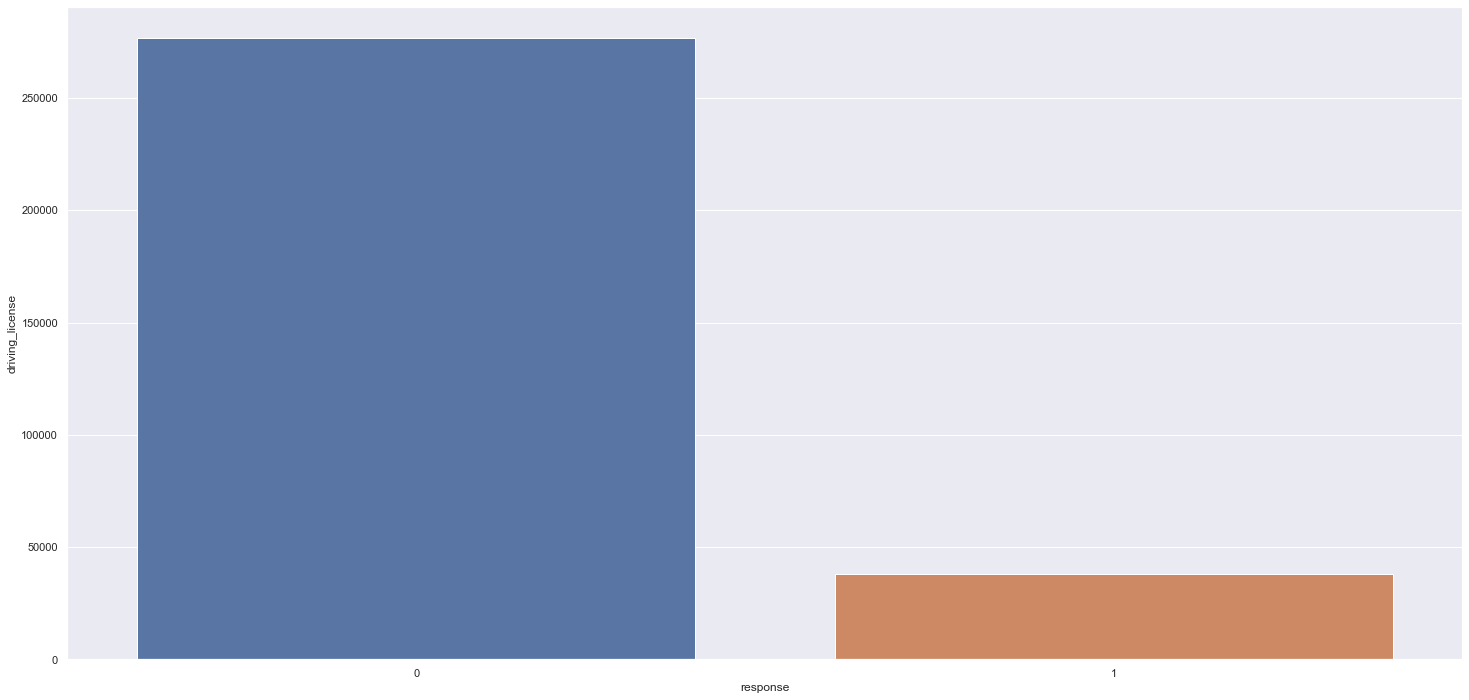

In [38]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

### 4.1.5. Region Code

<AxesSubplot:xlabel='region_code', ylabel='id'>

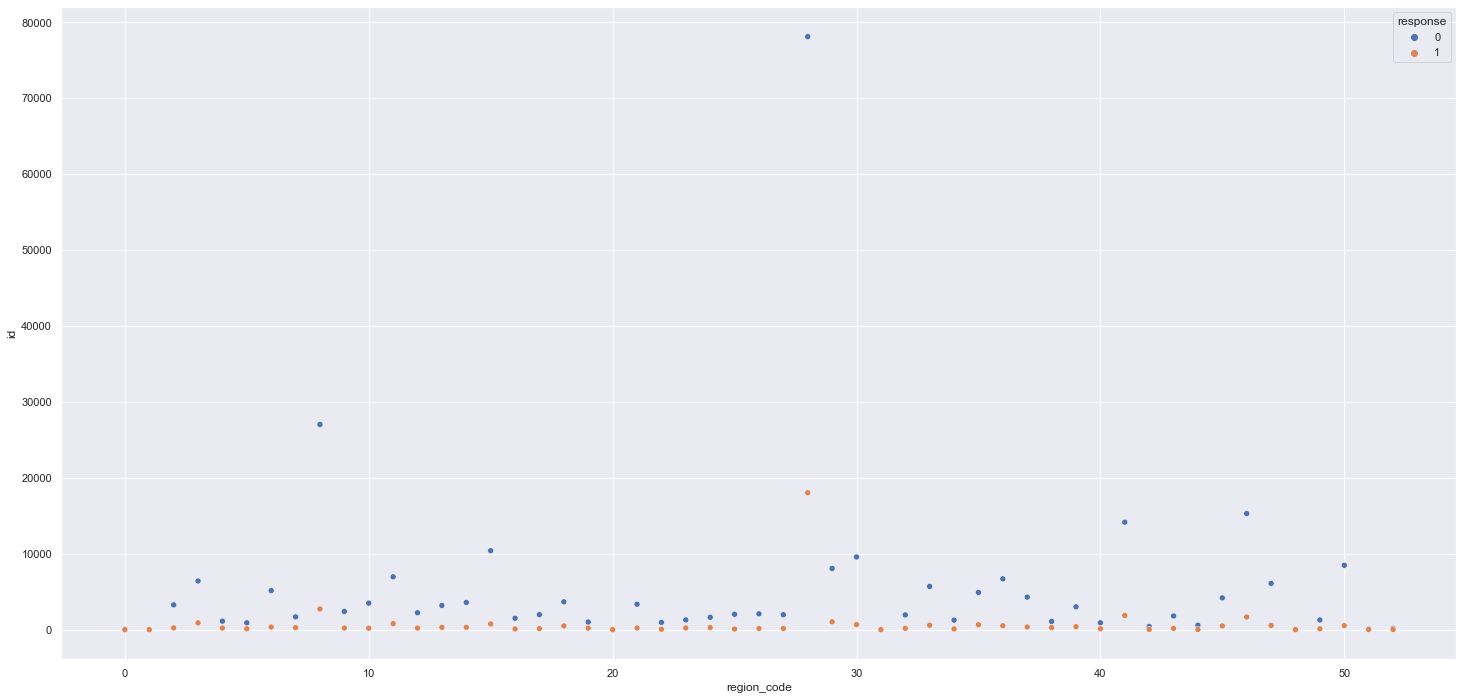

In [55]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
# aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

### 4.1.6. Previously Insured

In [41]:
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


### 4.1.7. Vehicle Age

In [42]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,137861
1,below_1_year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


### 4.1.8. Vehicle Damage

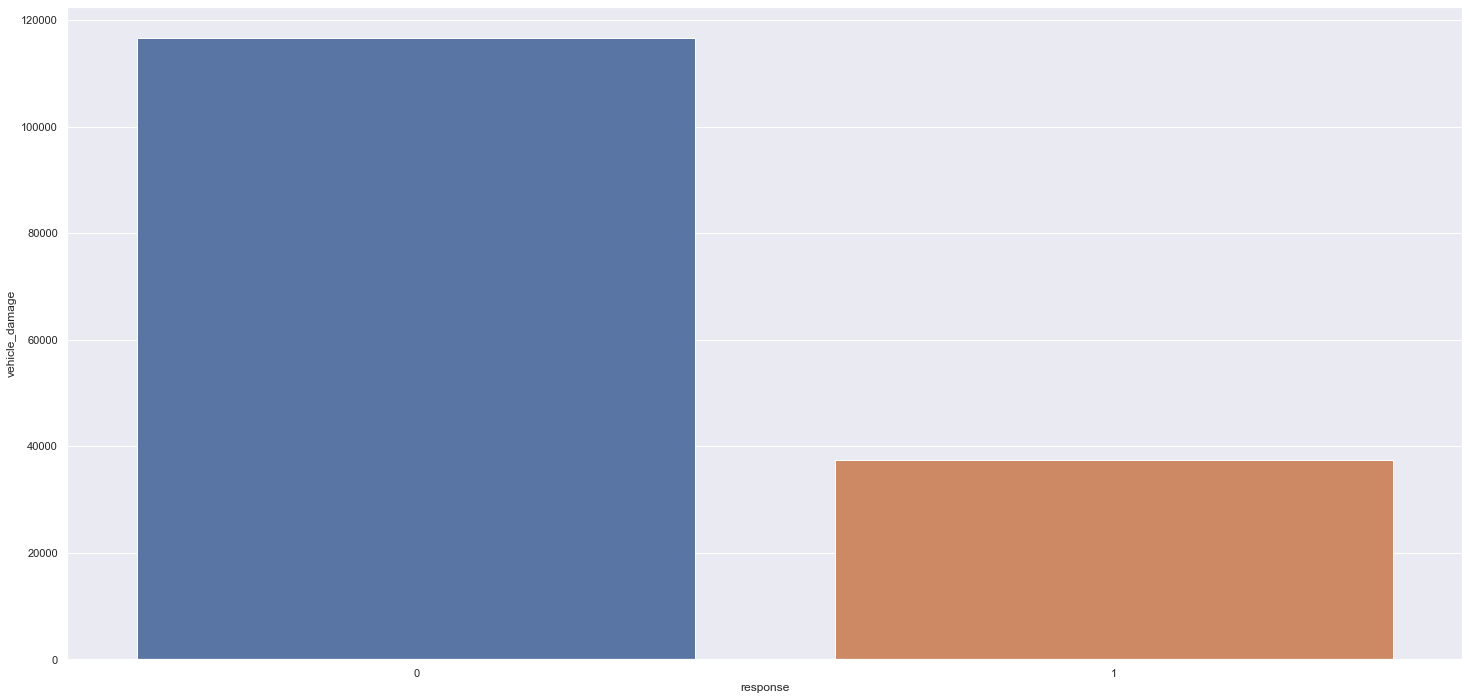

In [43]:
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.9. Policy Sales Channel - Stacked Percentage Bar

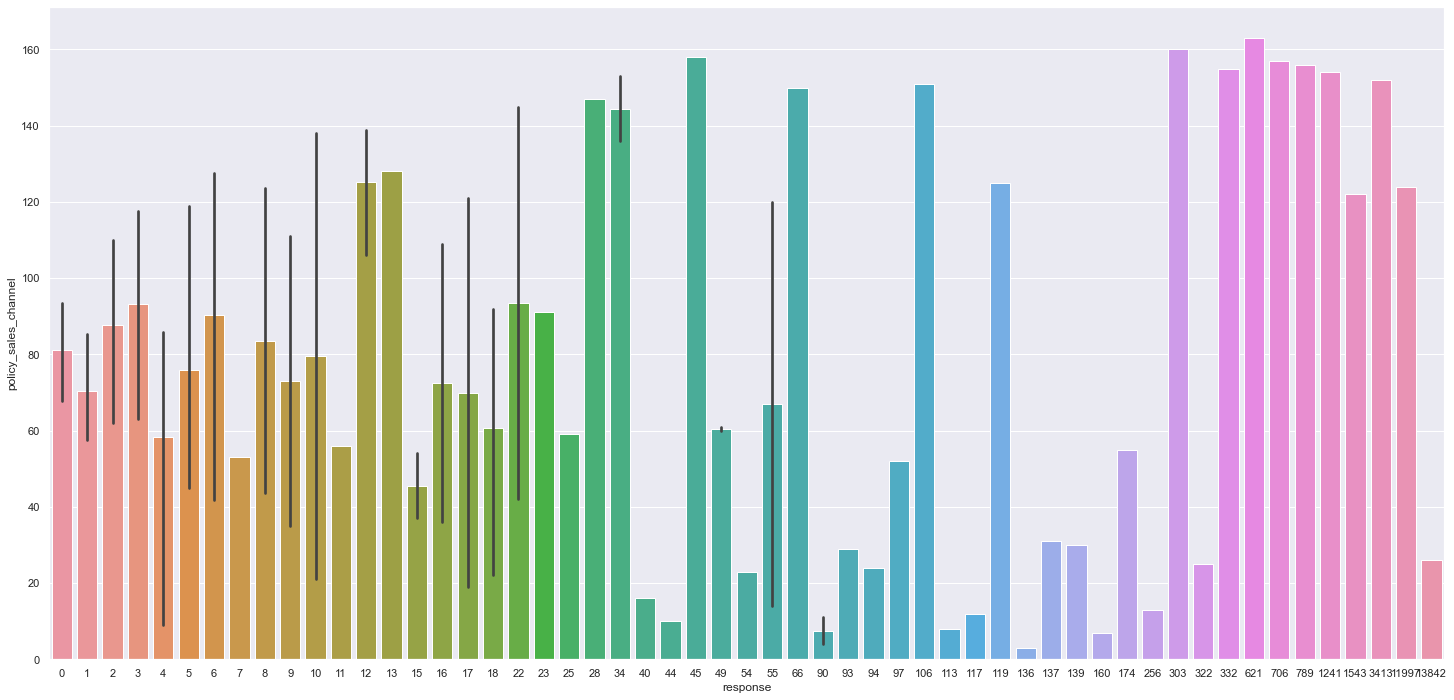

In [44]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

In [63]:
aux01 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df4[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux

,policy_sales_channel,response,total_responses
0,1.0,0,10
1,2.0,0,1
2,3.0,136,434
3,4.0,90,442
4,6.0,0,2
5,7.0,160,1356
6,8.0,113,1336
7,9.0,4,11
8,10.0,44,233
9,11.0,90,1026


### 4.1.10. Vintage

<AxesSubplot:xlabel='vintage', ylabel='Count'>

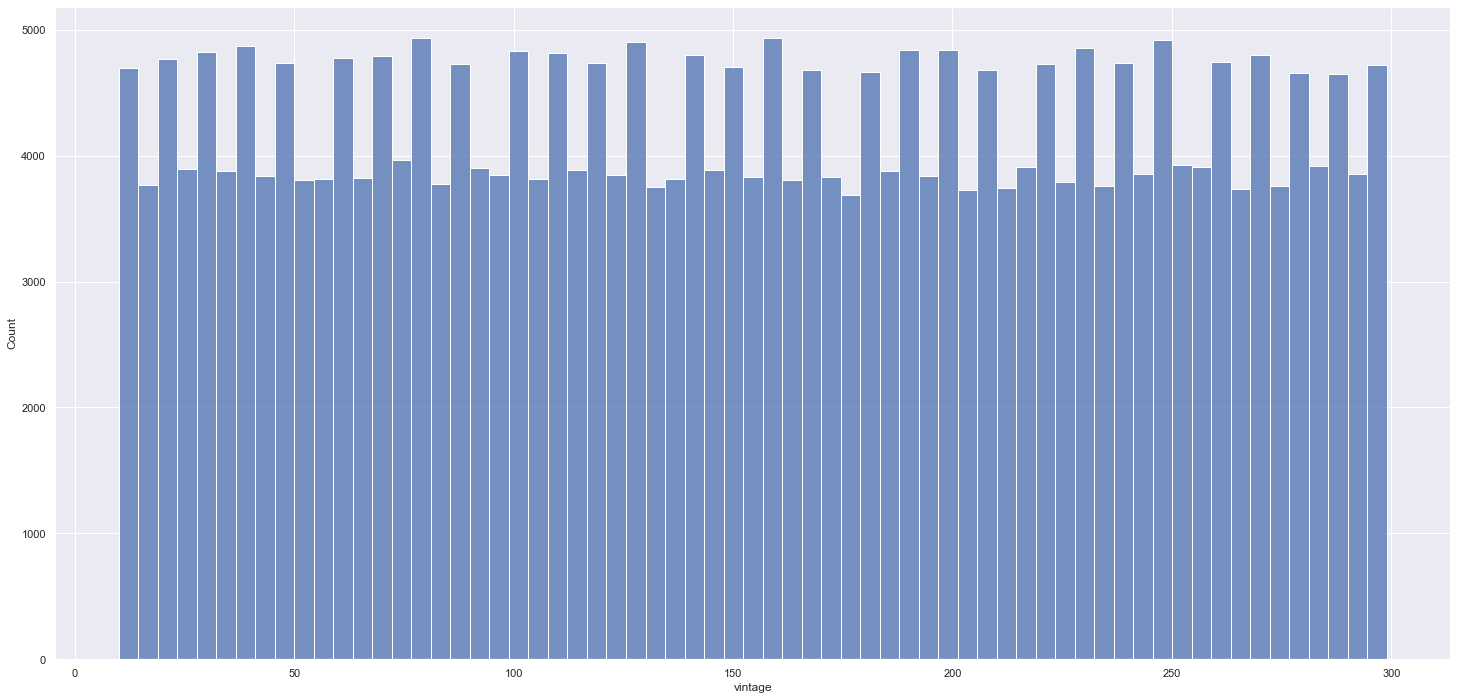

In [46]:
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

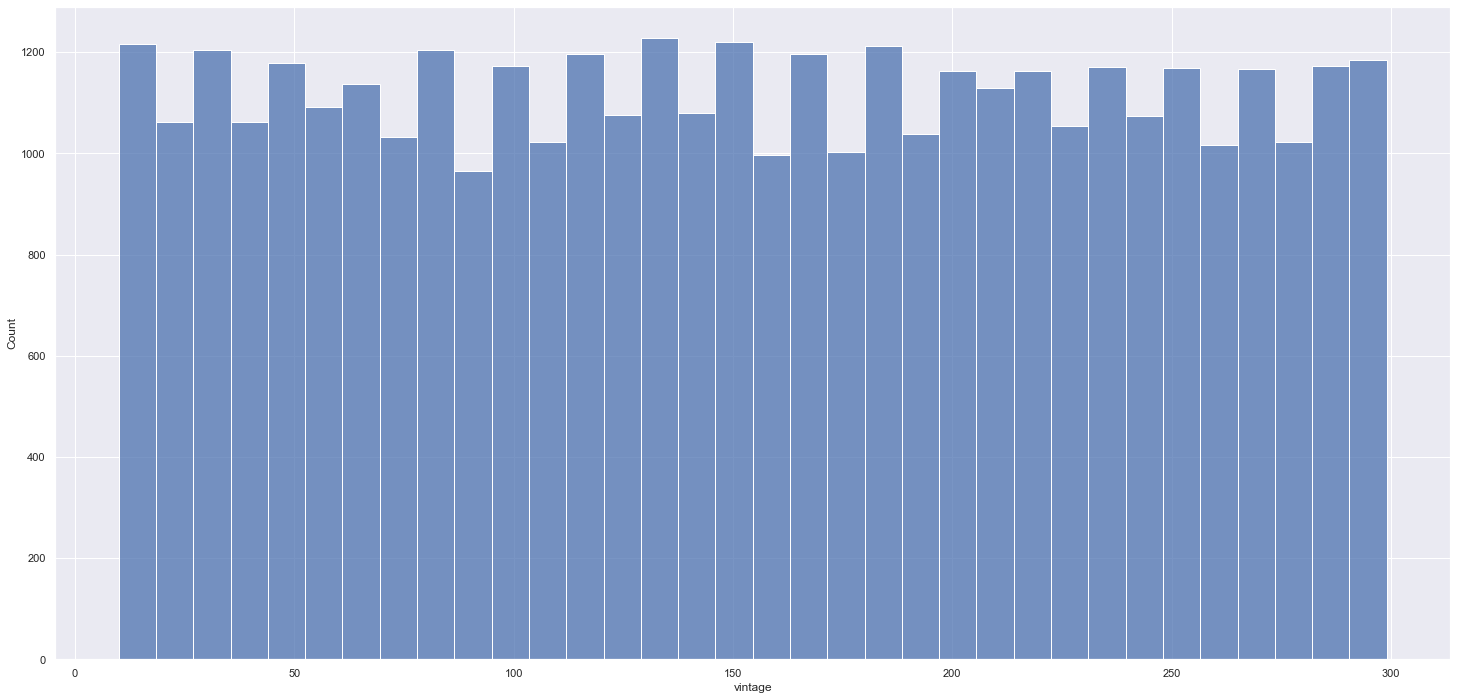

In [47]:
aux = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux )

### 4.1.11 Gender

In [62]:
aux=df4[['gender', 'response']].value_counts( normalize=True ).reset_index()
aux.columns=[['gender','response','percentage']]
aux

,gender,response,percentage
0,Male,0,0.460889
1,Female,0,0.418391
2,Male,1,0.074012
3,Female,1,0.046708


/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


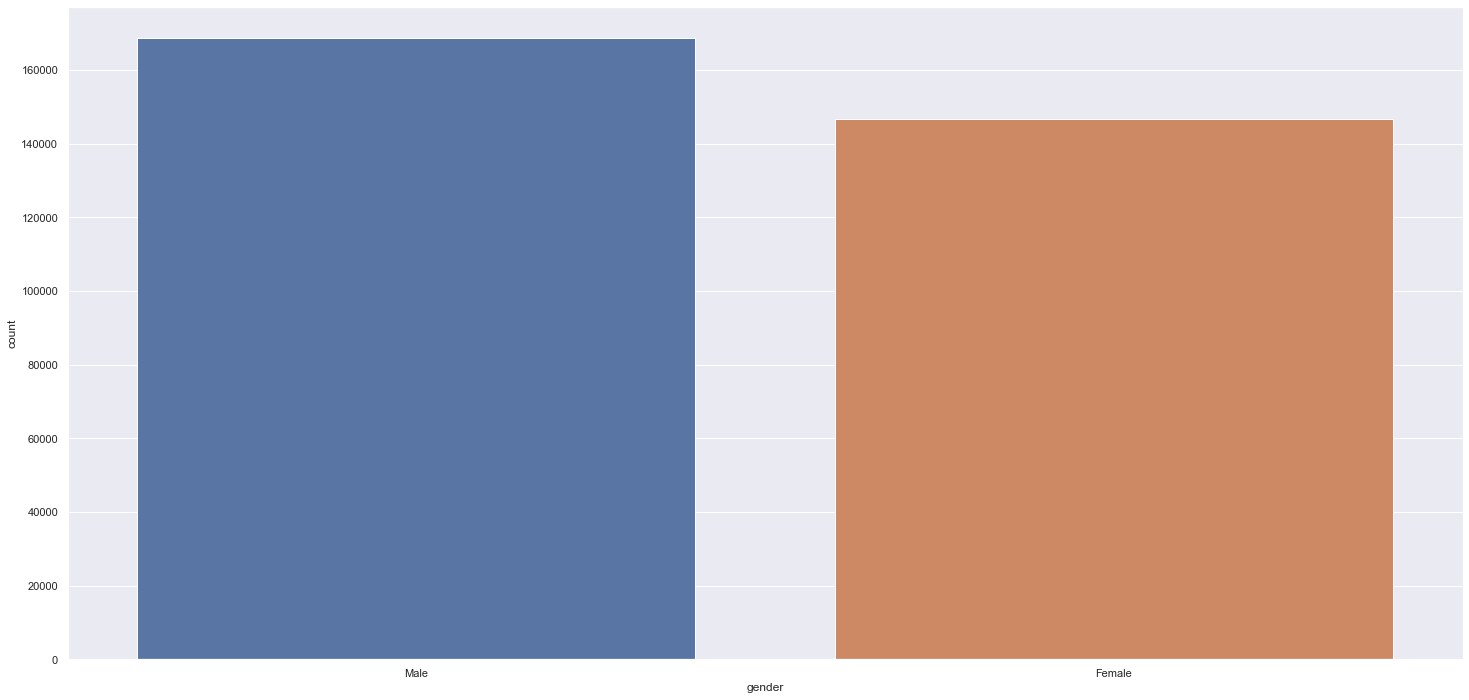

In [50]:
sns.countplot ( df4['gender']);

## 4.2 Bivariate Analysis

### **H1 -** Mulheres tem mais interesse em comprar seguro de veículos que homens.

**Falsa** - Homens tem mais interesse (61,31%) em comprar seguro de veículos do que mulheres (38,69%) 

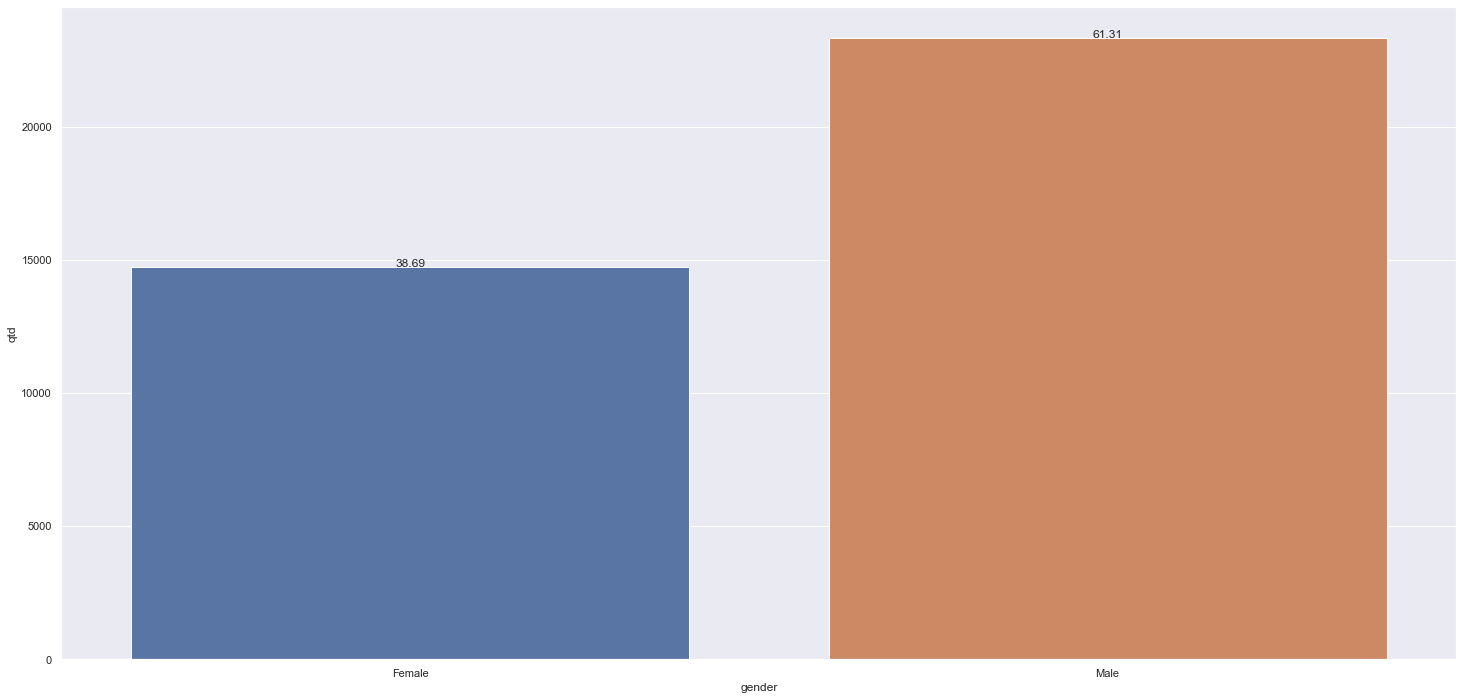

In [69]:
aux=df4[df4['response']==1]
aux=aux[['gender']].groupby('gender').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd')
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H2 - Clientes com carros novos/seminovos (menor que 2 anos), tem mais interesse em seguro de veículos.

**Verdadeira** - Cliente com carros seminovos e novos correspondem a aproximadamente 90% dos interessados em adquirir um seguro de veículo


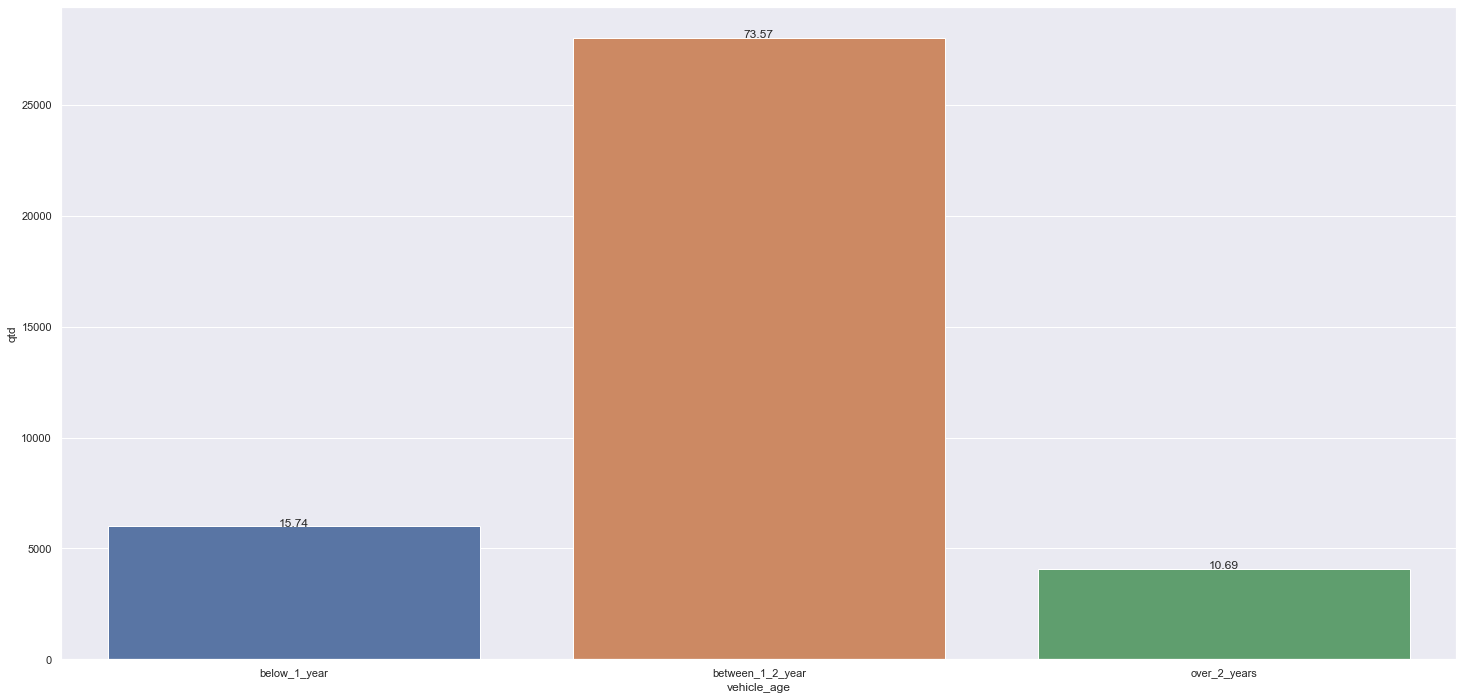

In [72]:
aux=df4[df4['response']==1]
aux=aux[['vehicle_age']].groupby('vehicle_age').size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='vehicle_age',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H3 - Clientes sem carteira de motorista não tem interesse algum em seguro de veículos.

**Falsa** - Uma pequena parcela de pessoas (0.01%), embora não tenham carteira de motorista estão interessados no seguro de veículos

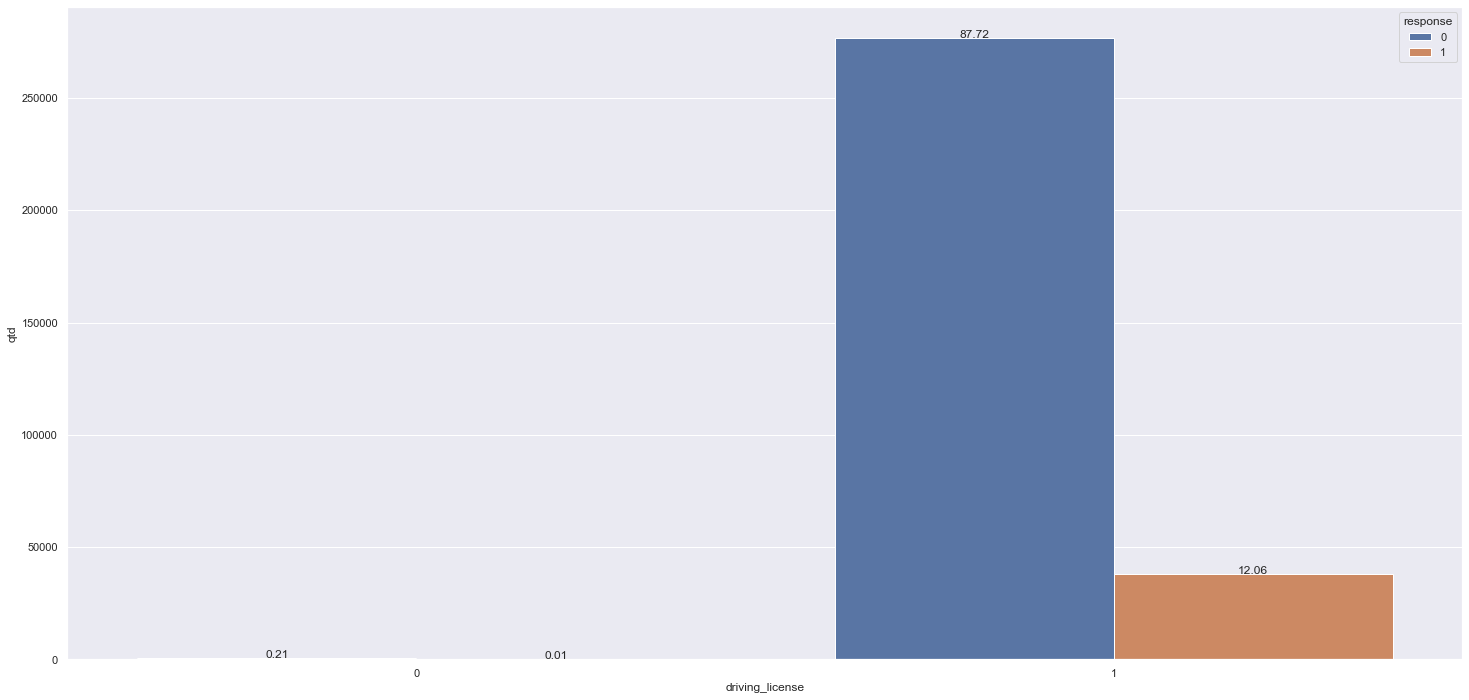

In [74]:
aux=df4[['driving_license','response']].groupby(['driving_license','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

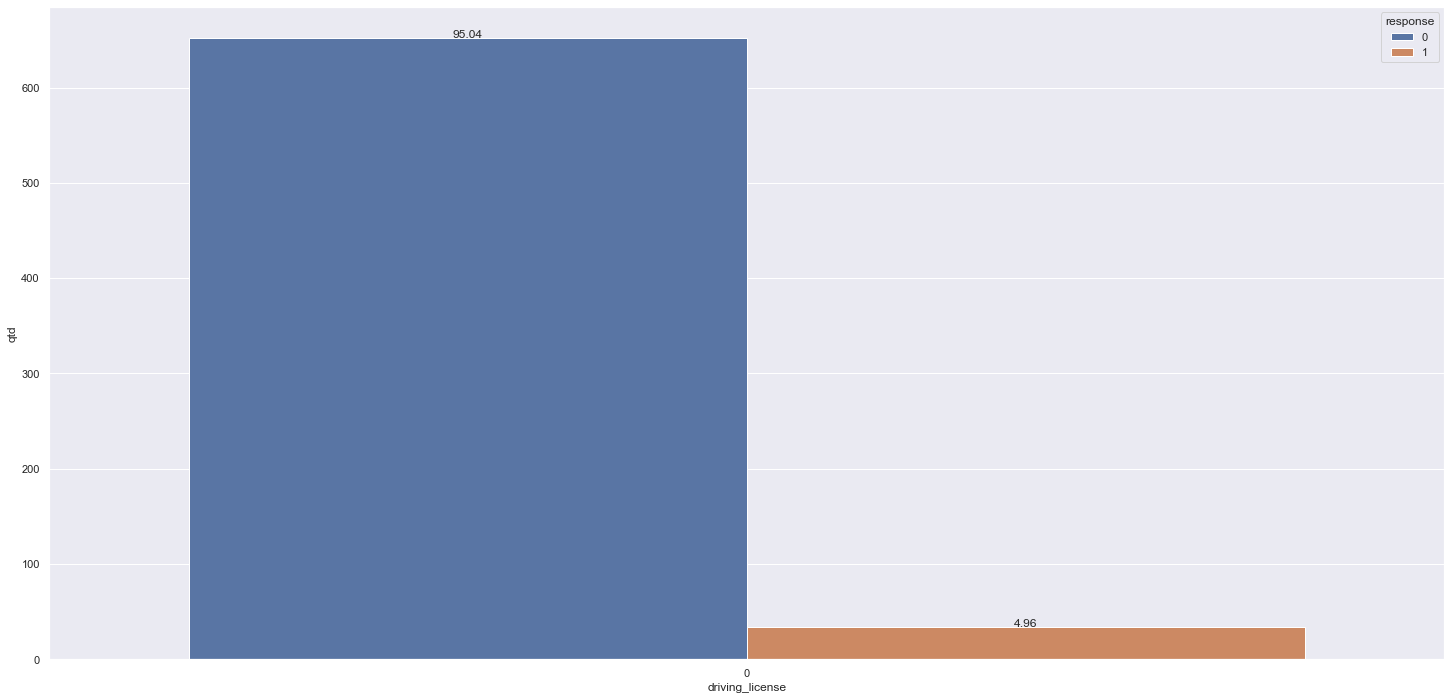

In [75]:
#Analise separada devida a pequena proporção
aux=aux[aux['driving_license']==0]
ax=sns.barplot(data=aux,x='driving_license',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H4 - Clientes que ja sofreram algum acidente tem mais interesse em adquirir seguro de veículos.

**Verdadeira** - 98% dos clientes interessados no seguro ja sofreram algum tipo de acidentes.

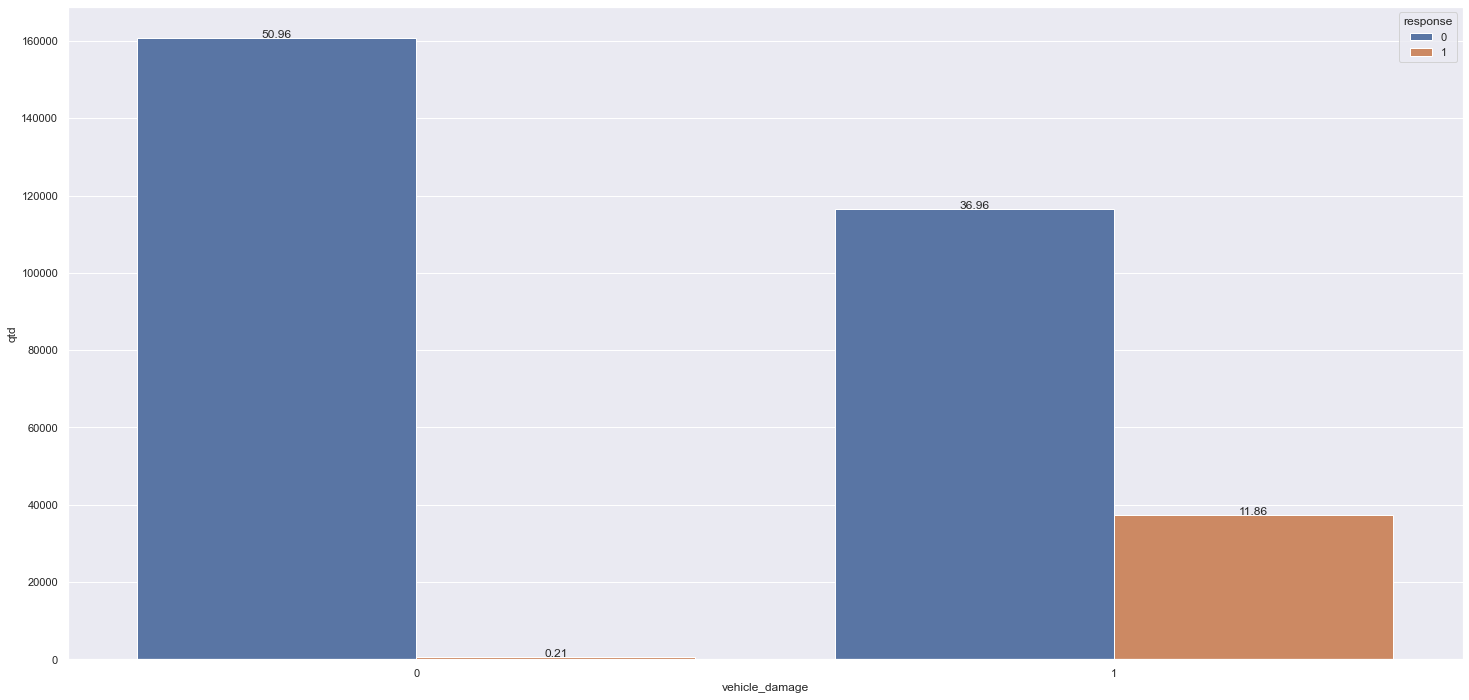

In [76]:
aux=df4[['vehicle_damage','response']].groupby(['vehicle_damage','response']).size().reset_index().rename(columns={0:'qtd'})
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

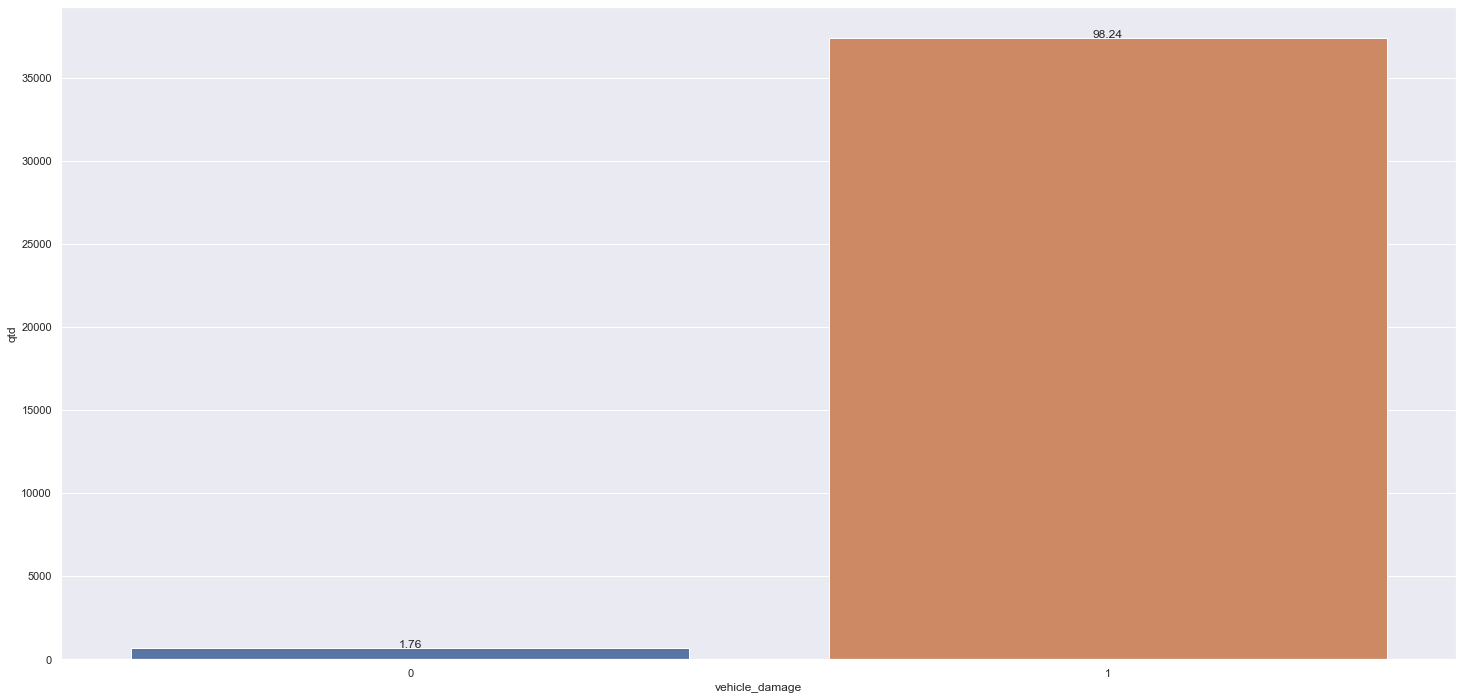

In [77]:
aux=aux[aux['response']==1]
ax = sns.barplot(data=aux,x='vehicle_damage',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H5 - Clientes acima de 30 anos são mais interessados em adquirir seguro de veículos.

**Verdadeira** - Aproximadamente 87% dos clientes interessados tem mais que 30 anos de idade

<AxesSubplot:xlabel='age', ylabel='qtd'>

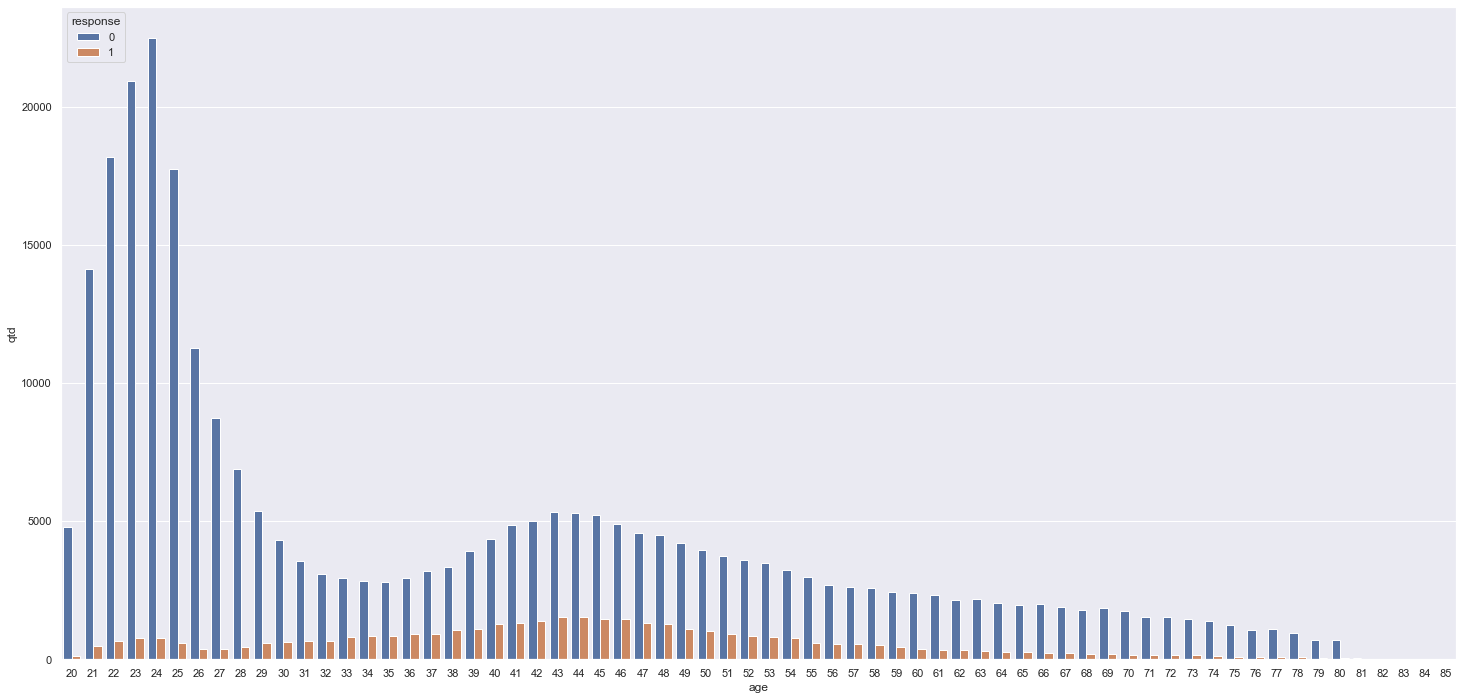

In [78]:
aux=df4[['age','response']].groupby(['age','response']).size().reset_index().rename(columns={0:'qtd'})
sns.barplot(data=aux,x='age',y='qtd',hue='response')

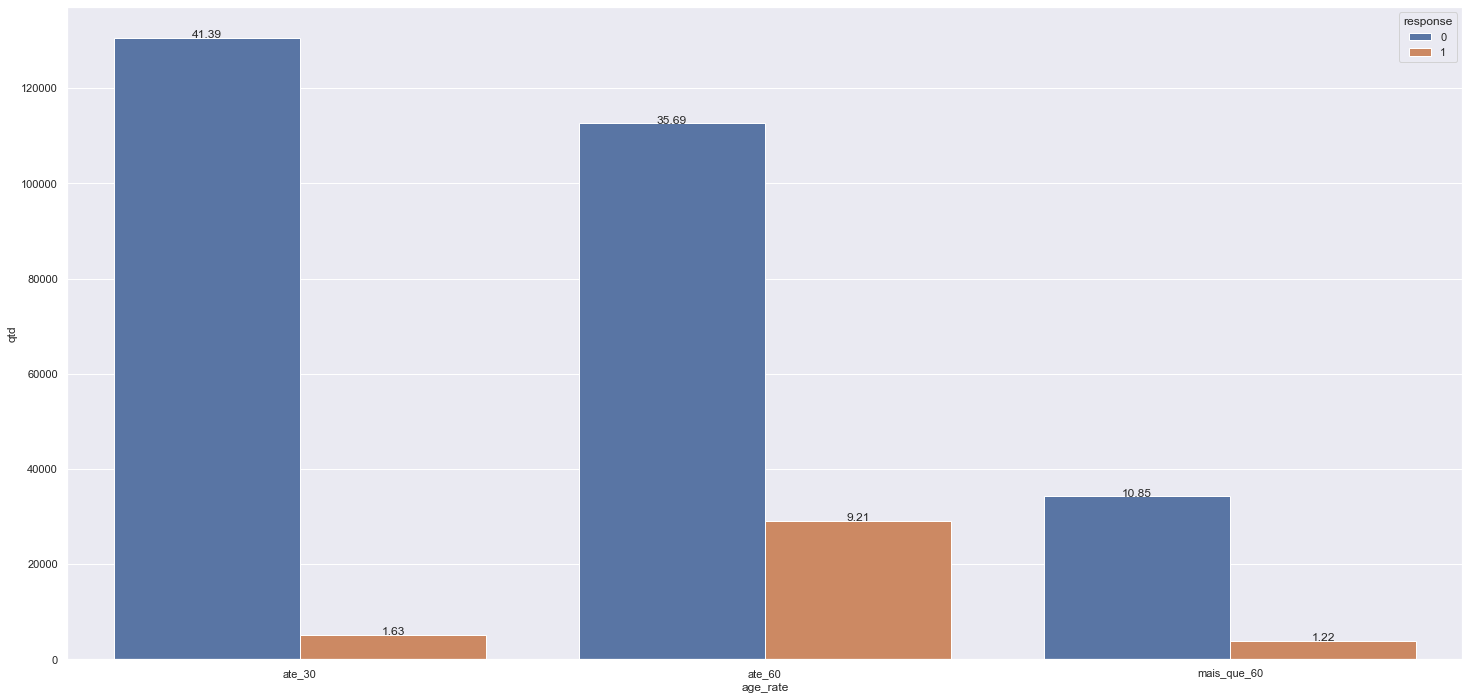

In [81]:
aux=df4.copy()
aux['age_rate']=df4['age'].apply(lambda x: 'ate_30' if x<30 else 'ate_60' if x>=30 and x<60 else 'mais_que_60')
aux=aux[['age_rate','response']].groupby(['age_rate','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='age_rate',y='qtd',hue='response');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

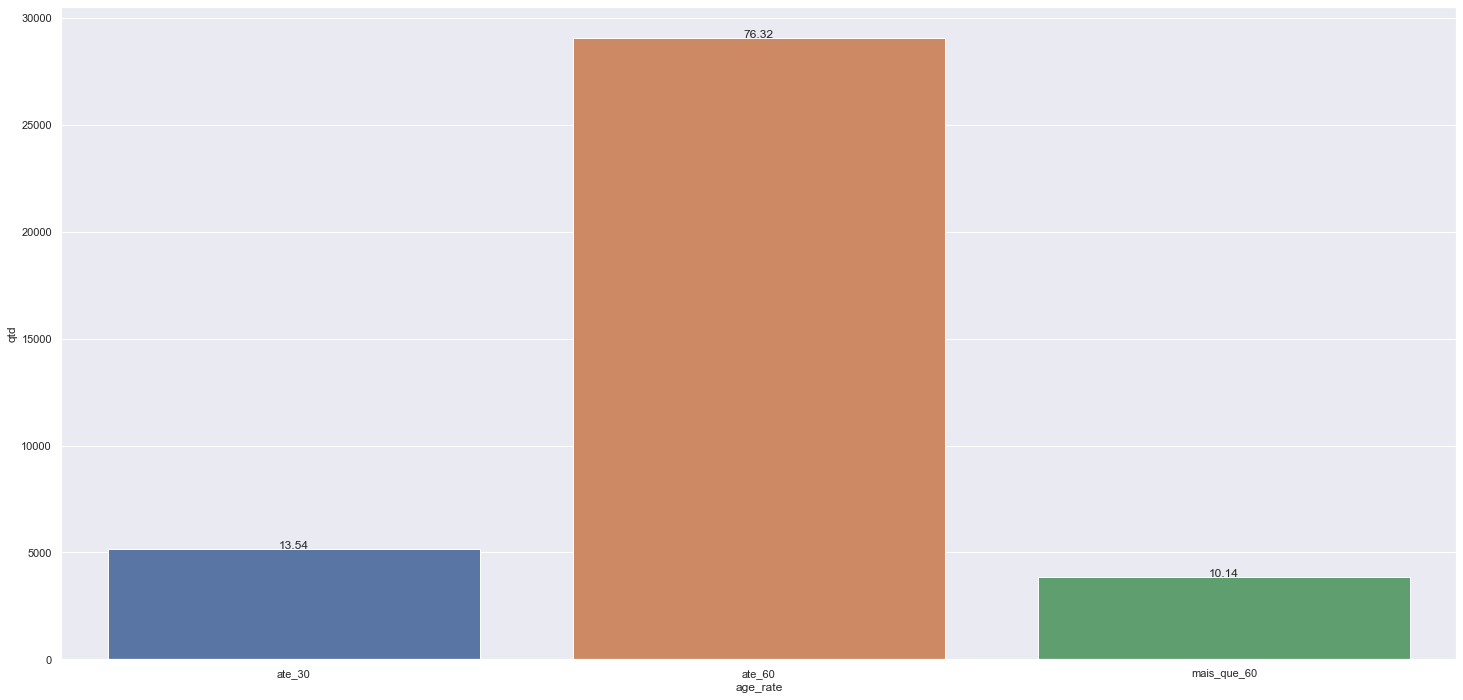

In [82]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='age_rate',y='qtd');
total=sum(aux['qtd'])

graphic_percentage(ax,total)

### H6 - Clientes que pagaram entre 30000 e 40000 para serem premium no ano(Annual Premium) tem mais interesse em adquirir seguro de veículos.

**Verdadeira** - Clientes que pagaram entre 30000 e 40000 correspondem à 39,38 dos clientes interessados em seguro de veículos

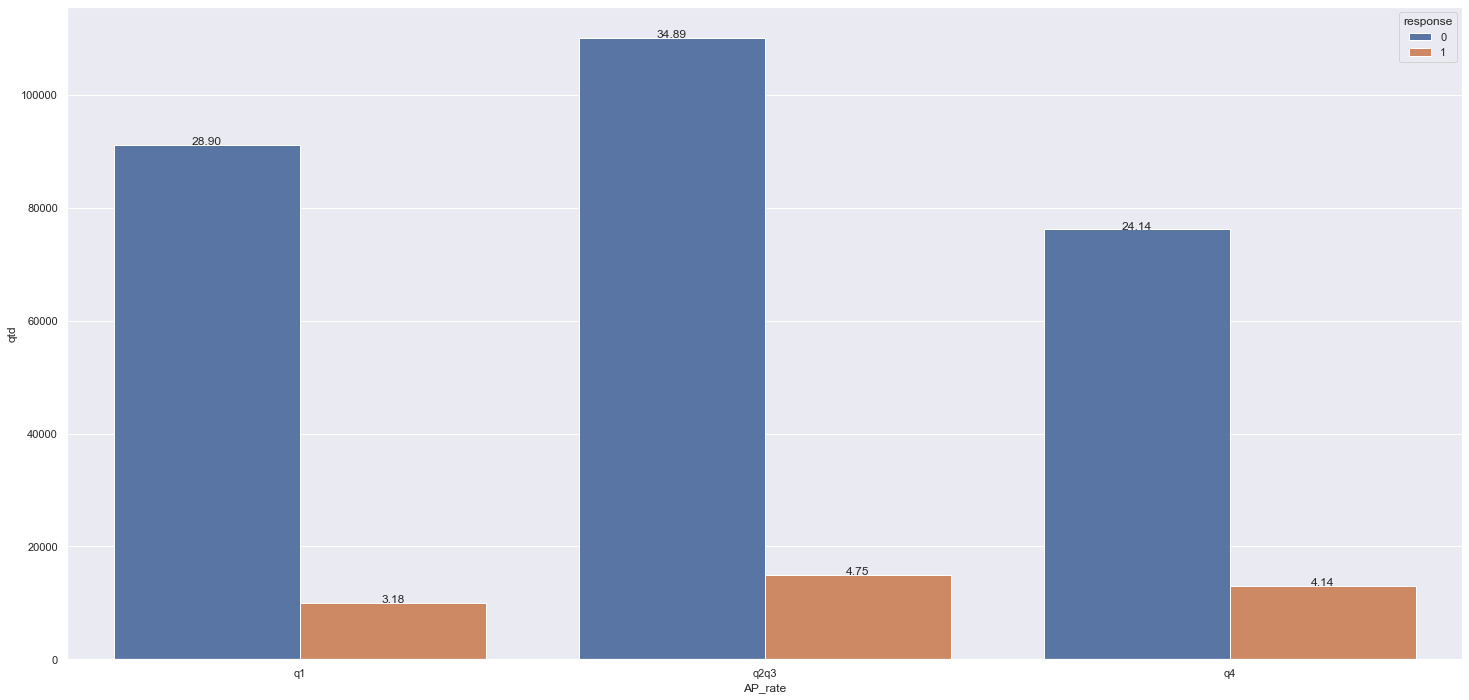

In [85]:
aux = df4.copy()
aux['AP_rate'] =aux['annual_premium'].apply(lambda x: 'q1' if x<30000 else 'q4' if x>40000 else 'q2q3')
aux=aux[['AP_rate','response']].groupby(['AP_rate','response']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='AP_rate',y='qtd',hue='response');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

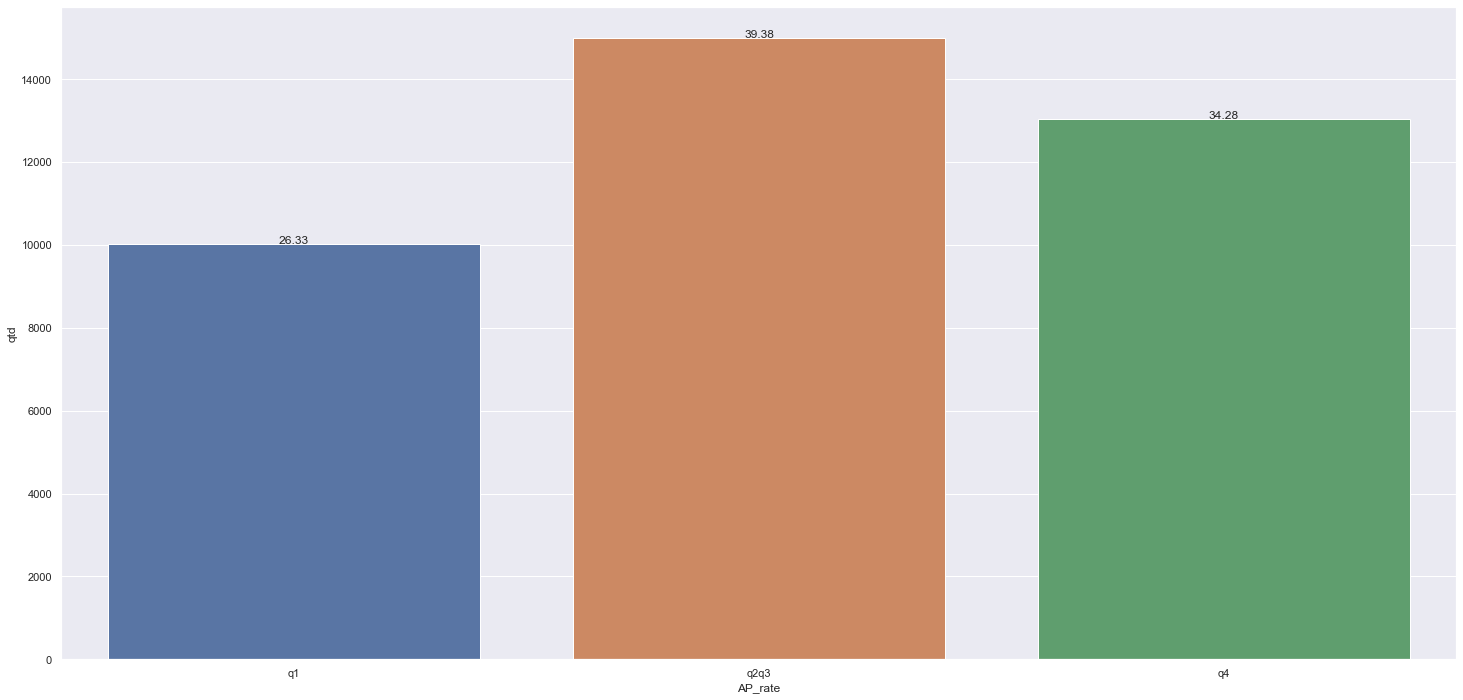

In [86]:
aux=aux[aux['response']==1]
ax=sns.barplot(data=aux,x='AP_rate',y='qtd');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### H7 - Homens tem mais eventos de dano a veículos, do que mulheres.

**Verdadeira** - Homens representam 58,39% dos eventos de dano à veículos, enquanto as mulheres representam 41,61% dos eventos.

In [88]:
 pd.crosstab( df4['gender'], df4['vehicle_damage'] )

vehicle_damage,0,1
gender,,
Female,82636,64079
Male,78797,89937


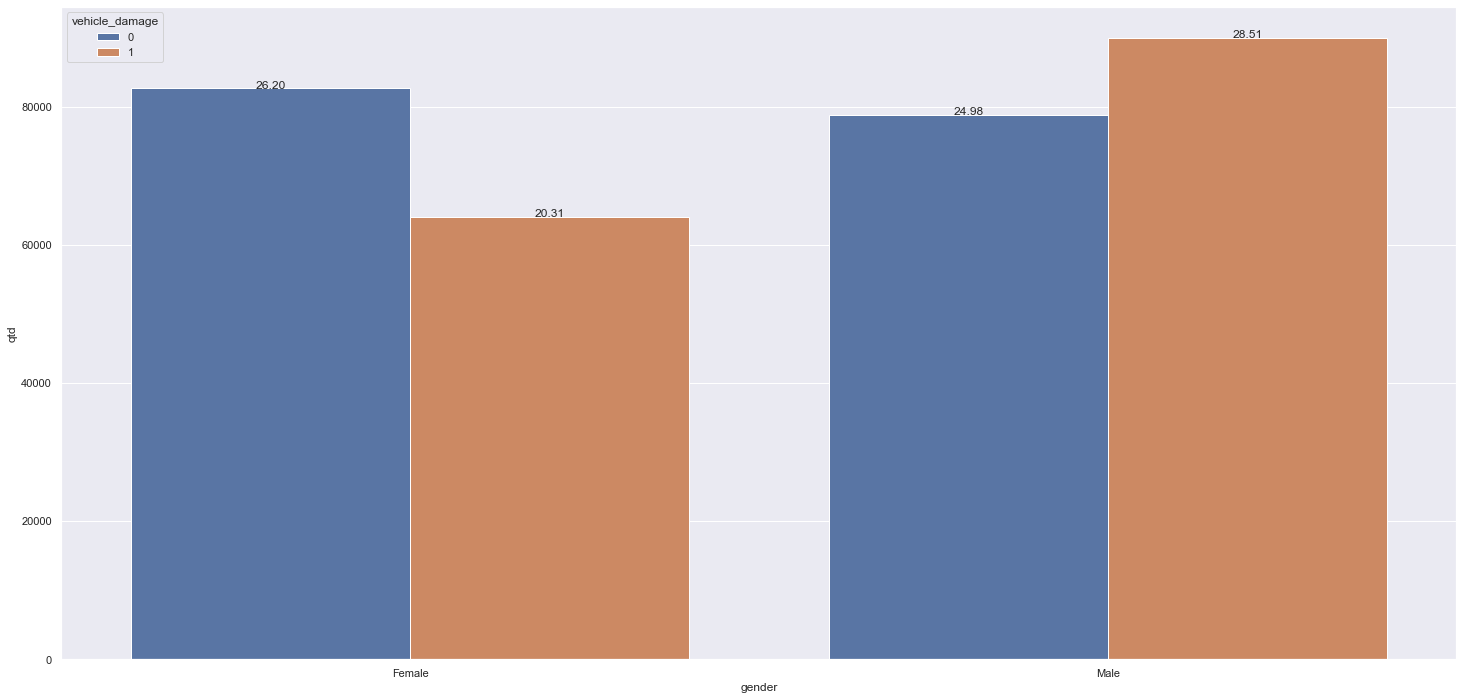

In [90]:
aux=df4[['vehicle_damage','gender']].groupby(['vehicle_damage','gender']).size().reset_index().rename(columns={0:'qtd'})
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

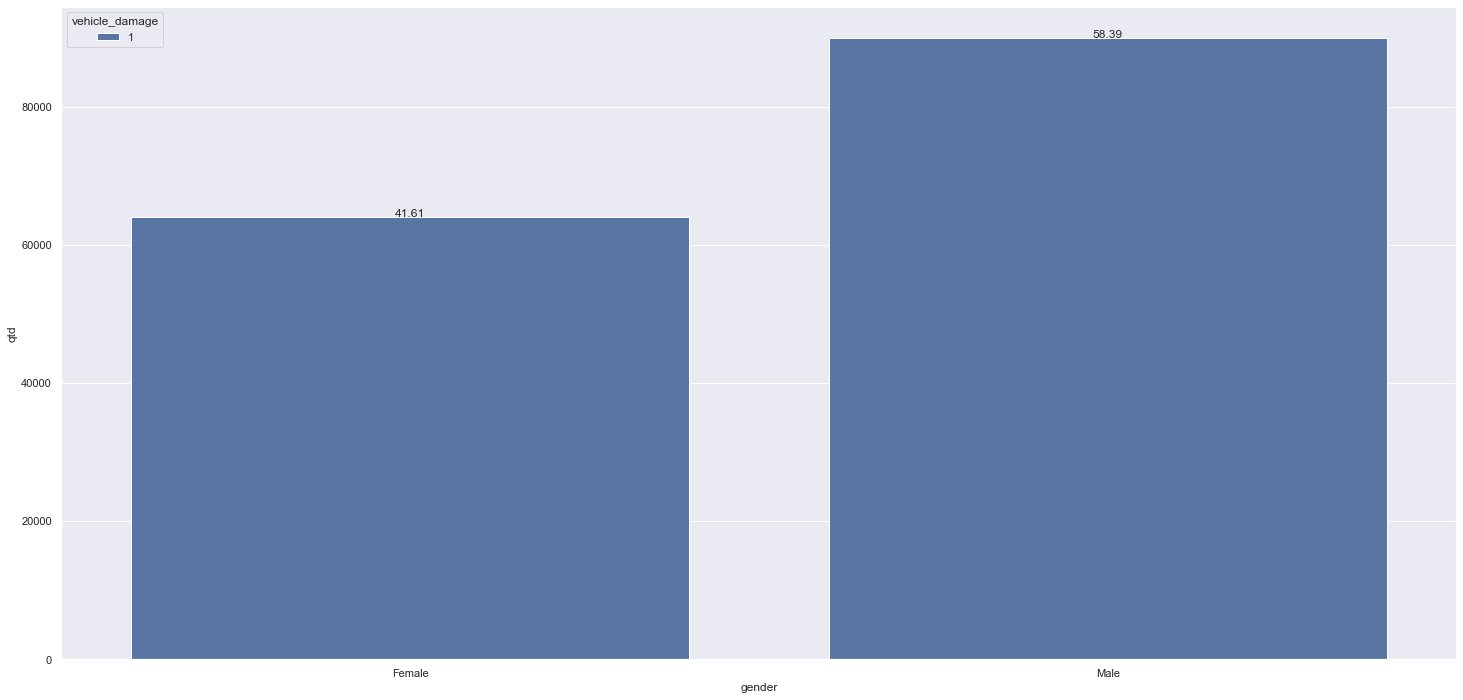

In [91]:
aux=aux[aux['vehicle_damage']==1]
ax=sns.barplot(data=aux,x='gender',y='qtd',hue='vehicle_damage');
total=sum(aux['qtd'])
graphic_percentage(ax,total)

### 4.2.1 Summary of Hypotheses

In [96]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Alta'],  
      ['H2', 'Verdadeira', 'Alta'],  
      ['H3', 'Falsa', 'Baixa'],
      ['H4', 'Verdadeira', 'Alta'],
      ['H5', 'Verdadeira', 'Média'],
      ['H6', 'Verdadeira', 'Média'],
      ['H7', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Alta
H2           Verdadeira   Alta
H3           Falsa        Baixa
H4           Verdadeira   Alta
H5           Verdadeira   Média
H6           Verdadeira   Média
H7           Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.2 Numerical Attributes

<AxesSubplot:>

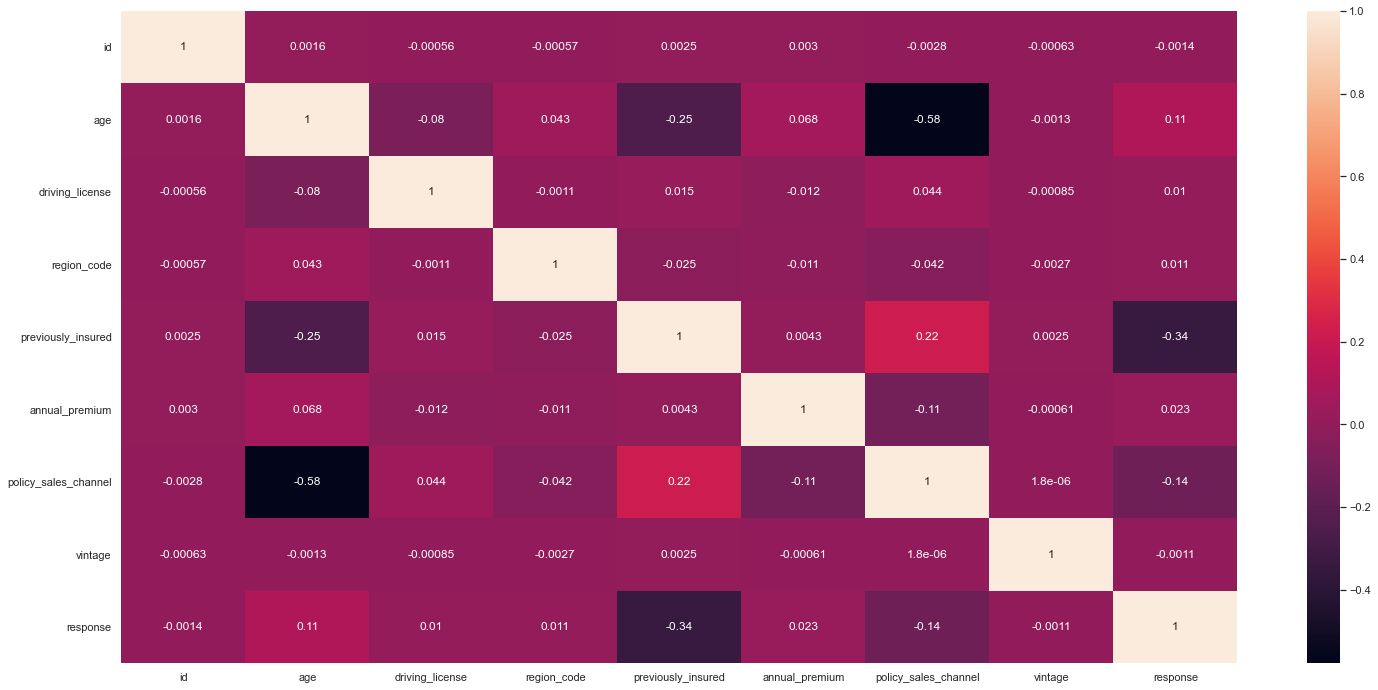

In [97]:
aux= num_attributes.corr()
sns.heatmap(aux,annot=True)

###  4.3.2. Categorical Attributes

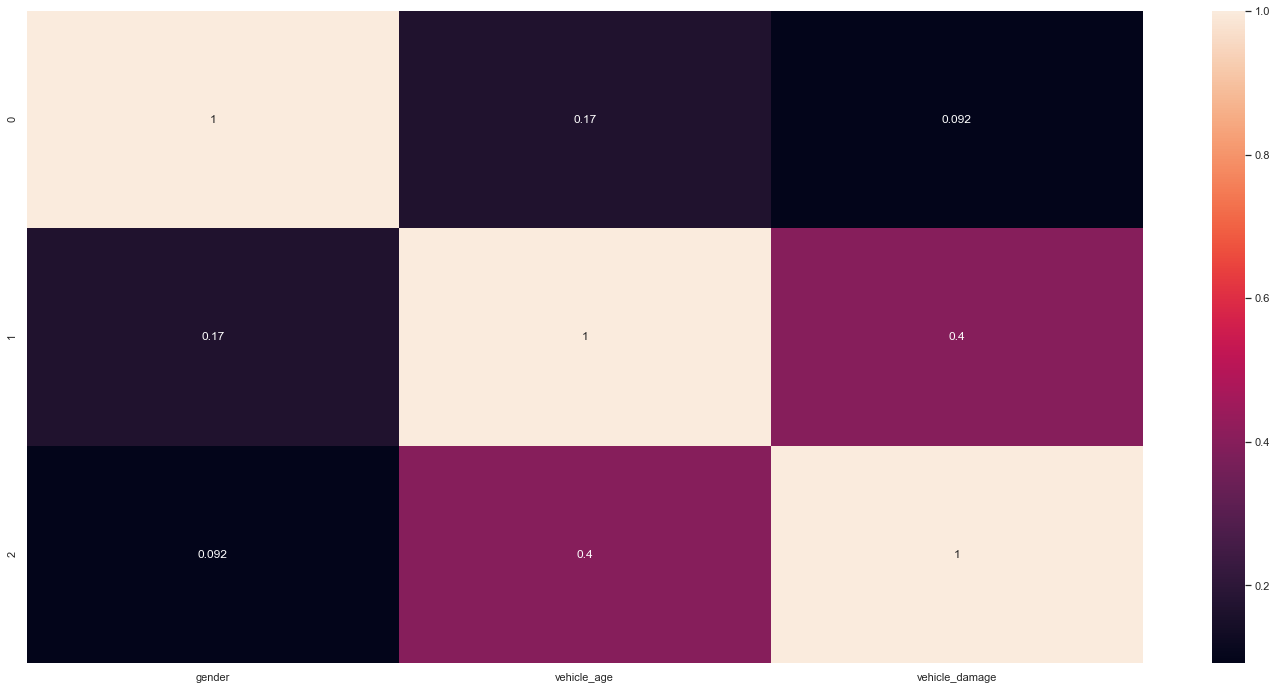

In [103]:
aux=pd.DataFrame(corr_cramer_v(cat_attributes))
sns.heatmap(aux,annot=True);

# 5.0. Data Preparation

In [32]:
df4=df3.copy()

## 5.1. Standardization

In [33]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )
pickle.dump( ss, open( '../src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [34]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df4['age'] = mms_age.fit_transform( df4[['age']].values )
pickle.dump( mms_age, open( '../src/features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df4['vintage'] = mms_vintage.fit_transform( df4[['vintage']].values )
pickle.dump( mms_vintage, open( '../src/features/vintage_scaler.pkl', 'wb' ) )

## 5.4. Transformation

### 5.4.1  One Hot Encoding

In [37]:
# gender 
target_encode_gender = df4.groupby( 'gender' )['response'].mean()
df4.loc[:, 'gender'] = df4['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '../src/features/target_encode_gender_scaler.pkl', 'wb' ) )

# vehicle_age 
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )


### 5.4.2 Target Encoding with Kfold

In [35]:
Region_Target_Enconderwkfold = KFoldTargetEncoder('region_code','response',n_fold=5)
pickle.dump( Region_Target_Enconderwkfold, open( '../src/features/target_encode_region_scaler.pkl', 'wb' ) )
df4 = Region_Target_Enconderwkfold.fit_transform(df4)


df4[['region_code_Kfold_Target_Enc','region_code']].head(6)

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, region_code_Kfold_Target_Enc and, response is 0.13542601401203228.


,region_code_Kfold_Target_Enc,region_code
0,0.110619,11.0
1,0.073495,15.0
2,0.126539,35.0
3,0.097199,8.0
4,0.097176,8.0
7,0.185900,28.0


In [36]:
PSC_Target_Enconderwkfold = KFoldTargetEncoder('policy_sales_channel','response',n_fold=5)
pickle.dump( PSC_Target_Enconderwkfold, open( '../src/features/target_encode_policy_sales_channel_scaler.pkl', 'wb' ) )
df4 = PSC_Target_Enconderwkfold.fit_transform(df4)

df4[['policy_sales_channel_Kfold_Target_Enc','region_code']].head(6)

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, policy_sales_channel_Kfold_Target_Enc and, response is 0.260578180505769.


,policy_sales_channel_Kfold_Target_Enc,region_code
0,0.028579,11.0
1,0.108911,15.0
2,0.028779,35.0
3,0.022092,8.0
4,0.190155,8.0
7,0.198822,28.0


## 5.3 Split Dataset

In [38]:
df4.drop(columns = [ 'policy_sales_channel', 'region_code', 'id'], inplace = True)

columns_order = ['gender', 
                 'age', 
                 'driving_license', 
                 'previously_insured',
                 'vehicle_damage', 
                 'annual_premium', 
                 'vintage',
                 'vehicle_age_below_1_year',
                 'vehicle_age_between_1_2_year',
                 'vehicle_age_over_2_years',
                 'region_code_Kfold_Target_Enc',
                 'policy_sales_channel_Kfold_Target_Enc', 
                 'response']

#keeping response as the last column for better slicing
df4 = df4.reindex(columns = columns_order)

### 5.3.1 Traning and validation data

In [39]:
msk = np.random.rand(len(df4)) < 0.80
train = df4[msk]
validation = df4[~msk]


In [40]:
x_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1:]

x_validation = validation.iloc[:, :-1]
y_validation = validation.iloc[:, -1:]

## 5.4 Target Variable Resampling

### 5.4.1 SMOTE + Tomek Links

In [41]:
print('Before ressampling')
y_train.value_counts()

Before ressampling


response
0           214444
1            29966
dtype: int64

In [42]:
#resample
x_train_res, y_train_res = SMOTETomek(random_state = 42).fit_resample(x_train, y_train)

In [43]:
print('After ressampling')
y_train_res.value_counts()

After ressampling


response
0           211795
1           211795
dtype: int64

# 6.0. Feature Selection

## 6.1 Feature Analysis

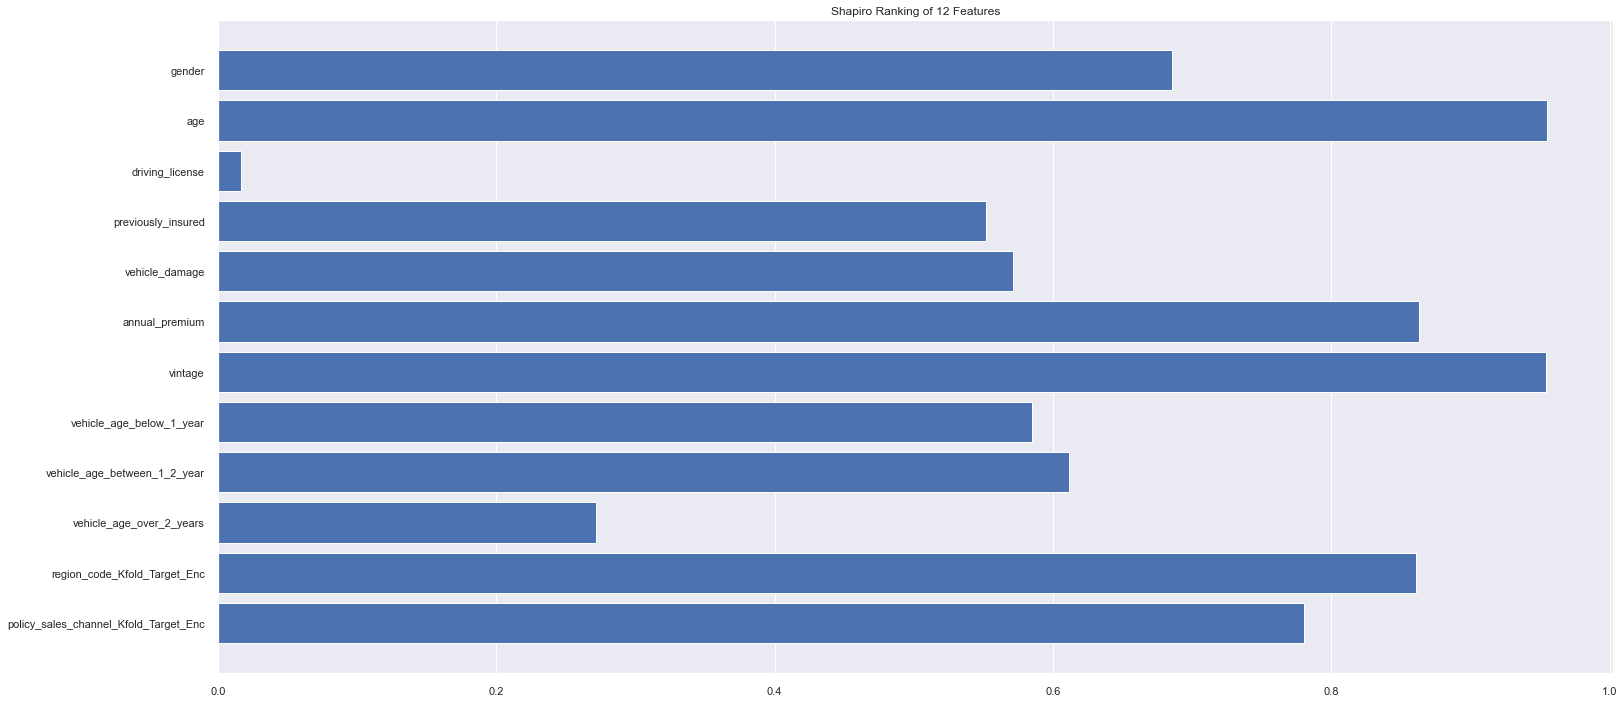

In [44]:
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x_train_res, y_train_res)           
visualizer.transform(x_train_res)        
visualizer.show(); 

## 6.2 Recursive Feature Elimination with Cross Validation

In [45]:
#preparing for selection
x_train_res_s = x_train_res.values
y_train_res_s = y_train_res.values.ravel()


Optimal number of features : 3


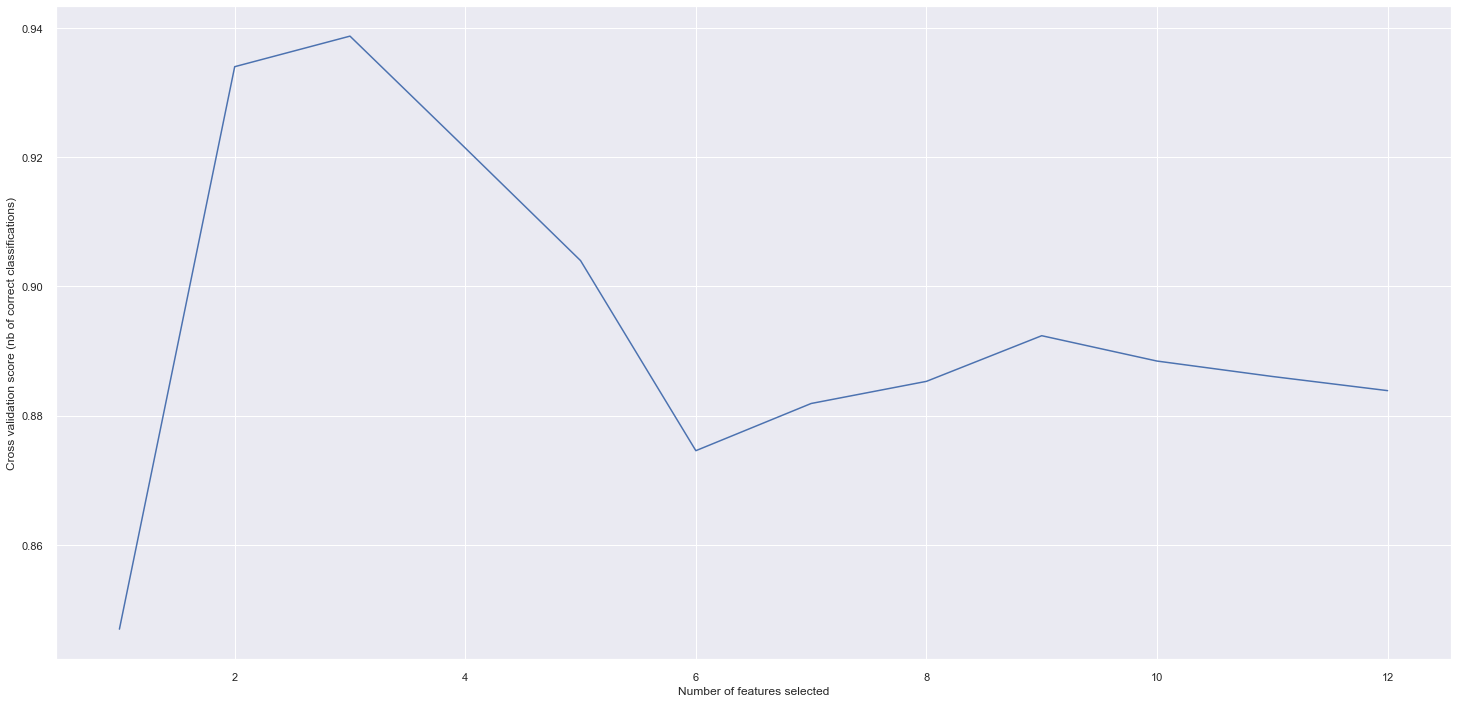

In [46]:
#Create the RFE object and compute a cross-validated score.
et = ExtraTreesClassifier( n_estimators = 100, n_jobs=-1, random_state=42 )

min_features_to_select = 1  # Minimum number of features to consider

rfeet = RFECV(estimator = et, step = 1, cv = StratifiedKFold(2),
              scoring = 'precision',
              min_features_to_select= min_features_to_select)

rfeet.fit(x_train_res_s, y_train_res_s)

print("Optimal number of features : %d" % rfeet.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfeet.grid_scores_) + min_features_to_select),
         rfeet.grid_scores_)
plt.show()

In [47]:
print('--- RFECV Selected Columns ---')
print(' ')

for i in range(x_train.shape[1]):
    
    if rfeet.support_[i] == True:
        print(str(df4.columns[i]))
        print('Rank: %.2f' % rfeet.ranking_[i])
        print(' ')
    else:
        pass

--- RFECV Selected Columns ---
 
age
Rank: 1.00
 
vehicle_damage
Rank: 1.00
 
policy_sales_channel_Kfold_Target_Enc
Rank: 1.00
 


## 6.3 Boruta Algorithm

In [48]:
# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )
rf = RandomForestClassifier( n_jobs = -1 )

# Define boruta
boruta = bt.BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_res_s, y_train_res_s  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	4
Iteration:

In [49]:
cols_selected = boruta.support_.tolist()

# best features
cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train.columns, cols_selected_boruta ) )

In [50]:
cols_selected_boruta

['gender',
 'age',
 'previously_insured',
 'vehicle_damage',
 'annual_premium',
 'vintage',
 'region_code_Kfold_Target_Enc',
 'policy_sales_channel_Kfold_Target_Enc']

In [51]:
cols_not_selected_boruta

['driving_license',
 'vehicle_age_below_1_year',
 'vehicle_age_between_1_2_year',
 'vehicle_age_over_2_years']

## 6.4 Feature Importance

In [52]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = x_train
y_train_n = y_train.values.ravel()
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                                 feature  importance
0                                vintage    0.214220
0                         annual_premium    0.188375
0  policy_sales_channel_Kfold_Target_Enc    0.156121
0           region_code_Kfold_Target_Enc    0.146698
0                                    age    0.142604
0                         vehicle_damage    0.074167
0                     previously_insured    0.049982
0               vehicle_age_below_1_year    0.013263
0           vehicle_age_between_1_2_year    0.006808
0                                 gender    0.004484
0               vehicle_age_over_2_years    0.002814
0                        driving_license    0.000462


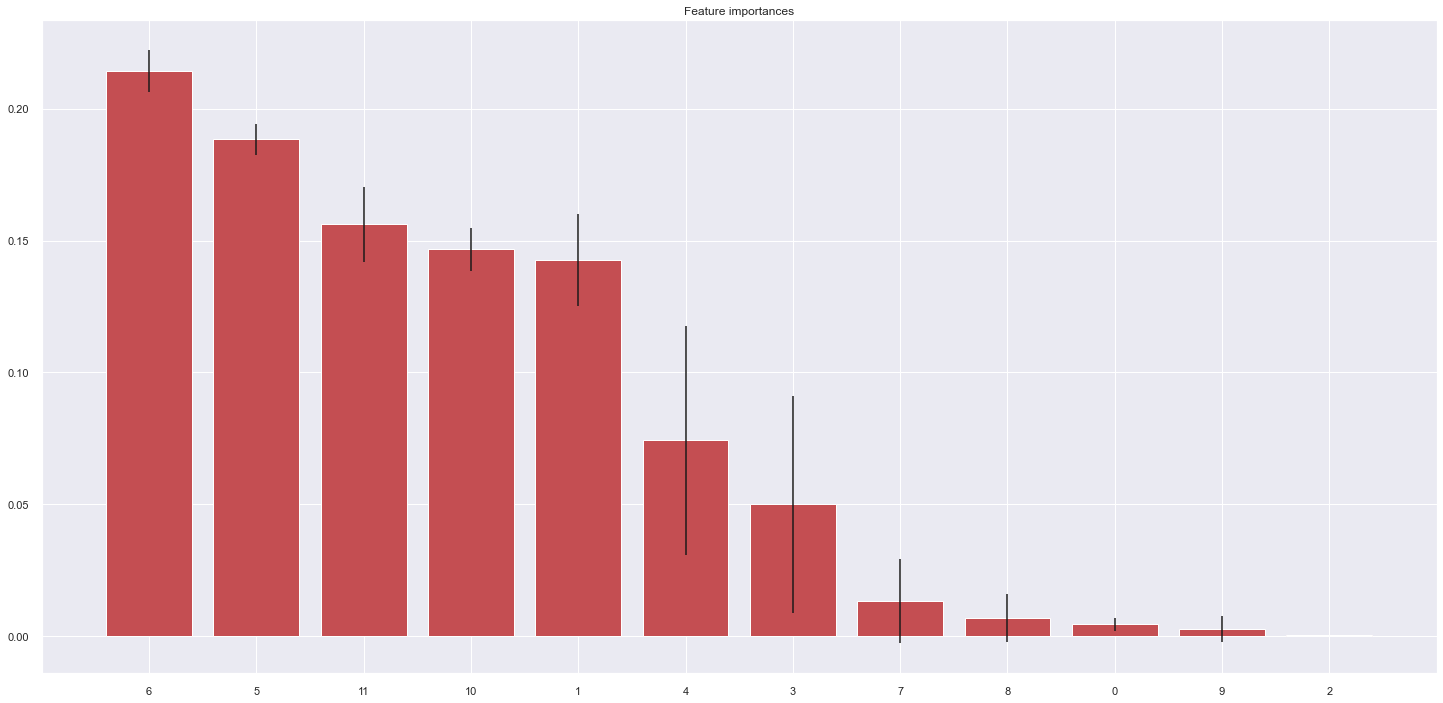

In [53]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()



# 7.0. Machine Learning Modelling

In [54]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code_Kfold_Target_Enc', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel_Kfold_Target_Enc']


In [38]:
x_train_res = x_train_res[cols_selected]
x_validation = x_validation[cols_selected]

## 7.1. KNN Classifier

In [55]:
#find best k
Ks = 15

mean_rcc = np.zeros((Ks-1))

for n in range(9,Ks):
    
    #Train Model and Predict  
    knn_model = nh.KNeighborsClassifier(n_neighbors = n).fit(x_train_res,y_train_res.values.ravel())
    yhat = knn_model.predict(x_validation)
    mean_rcc[n-1] = balanced_accuracy_score(y_validation, yhat)

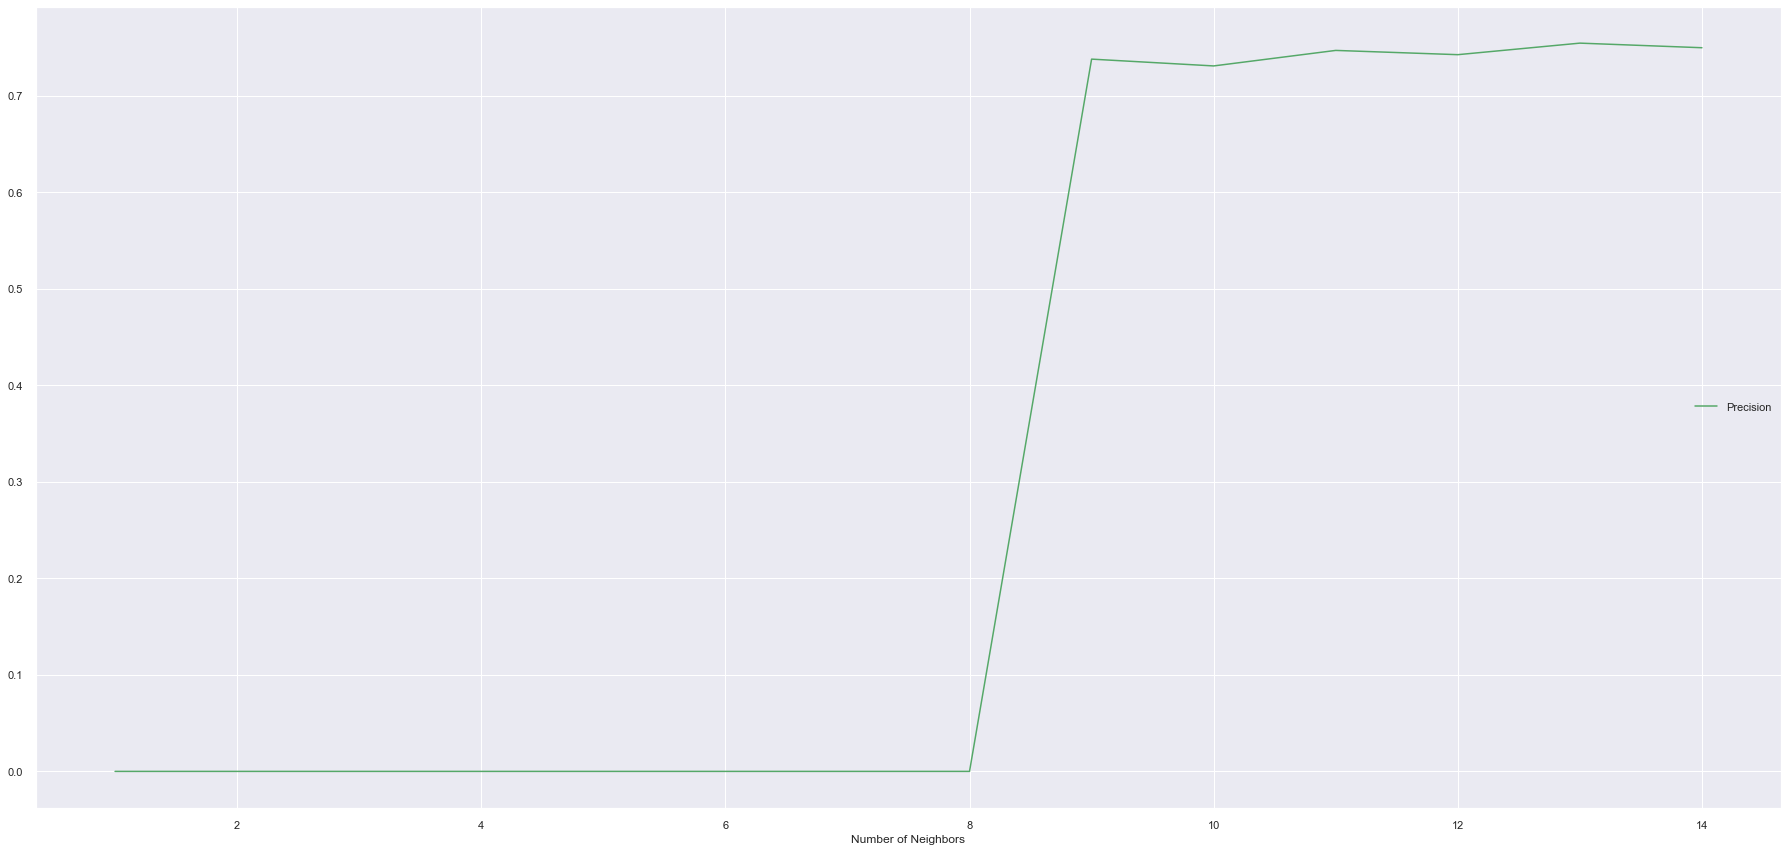

In [56]:
plt.plot(range(1,Ks),mean_rcc,'g')
plt.legend(('Precision', ), loc = 'center right' )
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [58]:
# model definition with k = 10
model_knn = nh.KNeighborsClassifier( n_neighbors = 10 )

# model training
model_knn.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_knn = model_knn.predict( x_validation ) 

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_knn)))

Balanced Accuracy: 0.7307793217799761


## 7.2. Logistic Regression

In [60]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 ) 

# model training
lr_model.fit( x_train_res, y_train_res.values.ravel() )

# model prediction  
yhat_lr = lr_model.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_lr)))

Balanced Accuracy: 0.7903214074570306


## 7.3. Naive Bayes



In [62]:
#model definition
model_nb = GaussianNB()

#train model
model_nb.fit( x_train_res, y_train_res.values.ravel() )

#prediction
yhat_nb = model_nb.predict( x_validation )
yhat_nb_1 = model_nb.predict_proba( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_nb)))

Balanced Accuracy: 0.7889246082141792


## 7.4. Random Forest

In [63]:
#model definition
model_rf = RandomForestClassifier(max_depth = 2, random_state = 0)

#train model
model_rf.fit( x_train_res, y_train_res.values.ravel() )

#predict
yhat_rf = model_rf.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_rf)))

Balanced Accuracy: 0.7901501165150275


## 7.5 LGBM

In [64]:
model_lgb=LGBMClassifier()
#model training
model_lgb.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_lgb = model_lgb.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_lgb)))

Balanced Accuracy: 0.5678637238356437


## 7.6 XGBoost

In [66]:
# model definition
model_xgb = xgb.XGBClassifier(n_estimators = 7, 
                              eta = 0.01, 
                              max_depth = 2, 
                              subsample = 0.7,
                              use_label_encoder = False,
                              eval_metric = 'aucpr',
                              colsample_bytree = 0.9)

#model training
model_xgb.fit( x_train_res, y_train_res.values.ravel() )

# prediction
yhat_xgb = model_xgb.predict( x_validation )

#metrics 
print('Balanced Accuracy: '   + str(balanced_accuracy_score(y_validation,yhat_xgb)))

Balanced Accuracy: 0.7714195245825338


## 7.7 Real Model Perfomance: Cross Validation with Learning to Rank metrics

In [67]:
df5=df4.copy()

In [68]:
xgb_val = cross_validation(model_xgb, x_train_res, y_train_res, 5, df5, Verbose = False)
lr_val = cross_validation(lr_model, x_train_res, y_train_res, 5, df5, Verbose = False)
lgb_val = cross_validation(model_lgb, x_train_res, y_train_res, 5, df5, Verbose = False)
nb_val = cross_validation(model_nb, x_train_res, y_train_res, 5, df5, Verbose = False)
rf_val = cross_validation(model_rf, x_train_res, y_train_res, 5, df5, Verbose = False)
knn_val= cross_validation(model_knn, x_train_res, y_train_res, 5, df5, Verbose = False)

In [69]:
results = pd.concat([xgb_val,lr_val,lgb_val,nb_val,rf_val,knn_val])
results.sort_values(by = 'Recall Mean', ascending = False)

,Model Name,Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,KNeighborsClassifier,0.8557,0.7921,0.0011,0.9647,0.0011,0.9307,0.0021,0.4394,0.0010
0,LogisticRegression,0.7965,0.7347,0.0017,0.9284,0.0018,0.7939,0.0016,0.3749,0.0008
0,RandomForestClassifier,0.7975,0.7431,0.0013,0.9093,0.0009,0.8463,0.0041,0.3996,0.0019
0,GaussianNB,0.7940,0.7431,0.0015,0.8985,0.0011,0.7724,0.0013,0.3647,0.0006
0,XGBClassifier,0.7852,0.7430,0.0018,0.8720,0.0014,0.7883,0.0327,0.3722,0.0154
0,LGBMClassifier,0.9109,0.9545,0.0021,0.8628,0.0024,1.0000,0.0001,0.4722,0.0000


# 8.0 Hyperparameter Fine Tuning

 We will proceed with both Gaussian Naive Bayes and LGBMClassifier, using Optuna framework to tune them.

In [93]:
def objective(trial):

        random_state = 42
        n_jobs = -1
        max_depth = -1
        n_estimators = trial.suggest_int("n_estimators", 200, 300)
        min_child_samples = trial.suggest_int(" min_child_samples", 1e-3, 2)
        min_child_weight = trial.suggest_int("min_child_weight", 10, 50)
    

        classifier_obj = LGBMClassifier(random_state       = random_state,
                                              n_jobs             = n_jobs,
                                              max_depth          =  max_depth,
                                              n_estimators       = n_estimators,
                                              min_child_samples  = min_child_samples,
                                              min_child_weight   = min_child_weight
                                              
                                             )

  
        result = cross_validation(classifier_obj, x_train_res, y_train_res, 5, df5, Verbose = False)
    
        return result['Recall Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Recall: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-08-14 21:34:46,321] A new study created in memory with name: no-name-59b52435-e4cc-4844-88cc-77af3ebe1069
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 21:35:07,974] Trial 0 finished with value: 0.8521 and parameters: {'n_estimators': 266, ' min_child_samples': 0, 'min_child_weight': 22}. Best is trial 0 with value: 0.8521.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 21:35:32,553] Trial 1 finished with value: 0.8519 and parameters: {'n_estimators': 298, ' min_child_samp

[I 2021-08-14 21:41:02,176] Trial 16 finished with value: 0.8526 and parameters: {'n_estimators': 300, ' min_child_samples': 0, 'min_child_weight': 29}. Best is trial 11 with value: 0.8527.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 21:41:35,539] Trial 17 finished with value: 0.8522 and parameters: {'n_estimators': 299, ' min_child_samples': 0, 'min_child_weight': 41}. Best is trial 11 with value: 0.8527.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 21:42:01,017] Trial 18 fin

[I 2021-08-14 21:49:33,892] Trial 33 finished with value: 0.852 and parameters: {'n_estimators': 293, ' min_child_samples': 0, 'min_child_weight': 23}. Best is trial 11 with value: 0.8527.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 21:50:04,308] Trial 34 finished with value: 0.8525 and parameters: {'n_estimators': 293, ' min_child_samples': 0, 'min_child_weight': 29}. Best is trial 11 with value: 0.8527.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 21:50:33,334] Trial 35 fini

[I 2021-08-14 21:58:13,412] Trial 50 finished with value: 0.8526 and parameters: {'n_estimators': 264, ' min_child_samples': 0, 'min_child_weight': 31}. Best is trial 41 with value: 0.8528.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 21:58:45,384] Trial 51 finished with value: 0.8526 and parameters: {'n_estimators': 283, ' min_child_samples': 0, 'min_child_weight': 28}. Best is trial 41 with value: 0.8528.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 21:59:08,782] Trial 52 fin

[I 2021-08-14 22:06:50,426] Trial 67 finished with value: 0.8526 and parameters: {'n_estimators': 299, ' min_child_samples': 0, 'min_child_weight': 36}. Best is trial 41 with value: 0.8528.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 22:07:24,084] Trial 68 finished with value: 0.8528 and parameters: {'n_estimators': 284, ' min_child_samples': 0, 'min_child_weight': 31}. Best is trial 41 with value: 0.8528.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 22:07:56,985] Trial 69 fin

[I 2021-08-14 22:16:08,193] Trial 84 finished with value: 0.8528 and parameters: {'n_estimators': 294, ' min_child_samples': 0, 'min_child_weight': 33}. Best is trial 41 with value: 0.8528.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 22:16:42,250] Trial 85 finished with value: 0.8526 and parameters: {'n_estimators': 297, ' min_child_samples': 0, 'min_child_weight': 31}. Best is trial 41 with value: 0.8528.
/home/luke/.pyenv/versions/3.8.0/envs/Health_Insurance_Cross_Sell/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning: The distribution is specified by [0.001, 2] and step=1, but the range is not divisible by `step`. It will be replaced by [0.001, 1.001].
  warnings.warn(
[I 2021-08-14 22:17:13,946] Trial 86 fin

Recall: 0.8528
Best hyperparameters: {'n_estimators': 280, ' min_child_samples': 0, 'min_child_weight': 31}


In [94]:
def objective(trial):

        
       
        var_smoothing = trial.suggest_float('var_smoothing',1e-9, 1, log = True )
        

        classifier_obj = GaussianNB( var_smoothing = var_smoothing )
        

        result = cross_validation(classifier_obj, x_train_res, y_train_res, 5, df5, Verbose = False)
        
        return result['Recall Mean'][0]


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

trial = study.best_trial

print('Recall: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-08-14 22:31:20,214] A new study created in memory with name: no-name-f76f27a4-0687-4a06-9de3-623ec91e1198
[I 2021-08-14 22:31:21,948] Trial 0 finished with value: 0.9787 and parameters: {'var_smoothing': 0.0003242885304109111}. Best is trial 0 with value: 0.9787.
[I 2021-08-14 22:31:23,623] Trial 1 finished with value: 0.9787 and parameters: {'var_smoothing': 1.0514993932279513e-09}. Best is trial 0 with value: 0.9787.
[I 2021-08-14 22:31:25,288] Trial 2 finished with value: 0.9787 and parameters: {'var_smoothing': 8.77637067487826e-07}. Best is trial 0 with value: 0.9787.
[I 2021-08-14 22:31:26,944] Trial 3 finished with value: 0.9787 and parameters: {'var_smoothing': 2.9689834660224487e-06}. Best is trial 0 with value: 0.9787.
[I 2021-08-14 22:31:28,601] Trial 4 finished with value: 0.9787 and parameters: {'var_smoothing': 1.1517790649129126e-07}. Best is trial 0 with value: 0.9787.
[I 2021-08-14 22:31:30,254] Trial 5 finished with value: 0.9787 and parameters: {'var_smoothin

[I 2021-08-14 22:32:42,940] Trial 48 finished with value: 0.9787 and parameters: {'var_smoothing': 0.12441388102913328}. Best is trial 13 with value: 0.979.
[I 2021-08-14 22:32:44,634] Trial 49 finished with value: 0.9787 and parameters: {'var_smoothing': 0.005940525010643507}. Best is trial 13 with value: 0.979.
[I 2021-08-14 22:32:46,329] Trial 50 finished with value: 0.9789 and parameters: {'var_smoothing': 0.4270259884835078}. Best is trial 13 with value: 0.979.
[I 2021-08-14 22:32:48,027] Trial 51 finished with value: 0.979 and parameters: {'var_smoothing': 0.9773270099944796}. Best is trial 13 with value: 0.979.
[I 2021-08-14 22:32:49,724] Trial 52 finished with value: 0.9788 and parameters: {'var_smoothing': 0.17629145342370314}. Best is trial 13 with value: 0.979.
[I 2021-08-14 22:32:51,426] Trial 53 finished with value: 0.979 and parameters: {'var_smoothing': 0.8287289113084357}. Best is trial 13 with value: 0.979.
[I 2021-08-14 22:32:53,120] Trial 54 finished with value: 0.97

[I 2021-08-14 22:34:06,075] Trial 97 finished with value: 0.9789 and parameters: {'var_smoothing': 0.5410363874896411}. Best is trial 13 with value: 0.979.
[I 2021-08-14 22:34:07,792] Trial 98 finished with value: 0.9788 and parameters: {'var_smoothing': 0.210374714864224}. Best is trial 13 with value: 0.979.
[I 2021-08-14 22:34:09,513] Trial 99 finished with value: 0.9787 and parameters: {'var_smoothing': 0.05051529623069464}. Best is trial 13 with value: 0.979.


Recall: 0.979
Best hyperparameters: {'var_smoothing': 0.7891545380597406}


# 9.0 Final Model

In [87]:
model_lgbm= LGBMClassifier()
#training
model_lgbm.fit( x_train_res, y_train_res.values.ravel() )

# model prediction
yhat_lgbm = model_lgbm.predict_proba(x_validation)

## 10.0 Business Perfomance

 By using 26,23% of test data, in which wold translate as 20 thousand calls by the sales team, the model would be able to identify 62.65% people out of the total people interested in purchasing the insurance.

In [88]:
data = x_validation.copy()

data['response'] = y_validation.copy()
#data['score'] = yhat_nb[:, 1].tolist()
data['score'] = yhat_lgbm[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [89]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)

print(percent_of_dataset)
print(recall_at_20000)

0.329777235477435
0.822950377562028


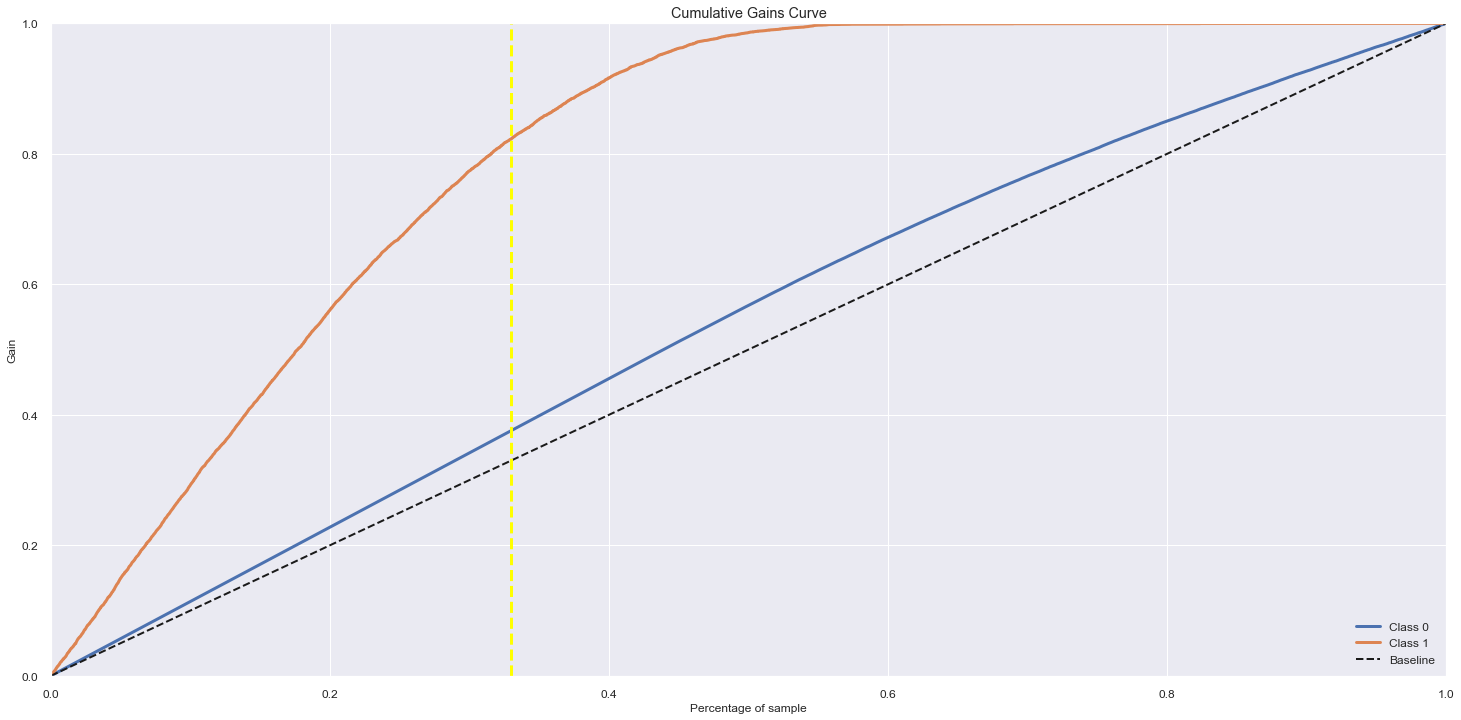

In [91]:
#skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(0.3297, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

By using a little less then 33% of test data, in which wold translate as 25 thousand and 1 hundred calls by the sales team, the model would be able to identify 78% people out of the total people interested in purchasing the insurance.

In [92]:
percent_of_dataset = 25100 / len(data)
recall_at_25100 = recall_at_k(data, k = 25100)

print(percent_of_dataset)
print(recall_at_25100)

0.41387043052418093
0.93042071197411


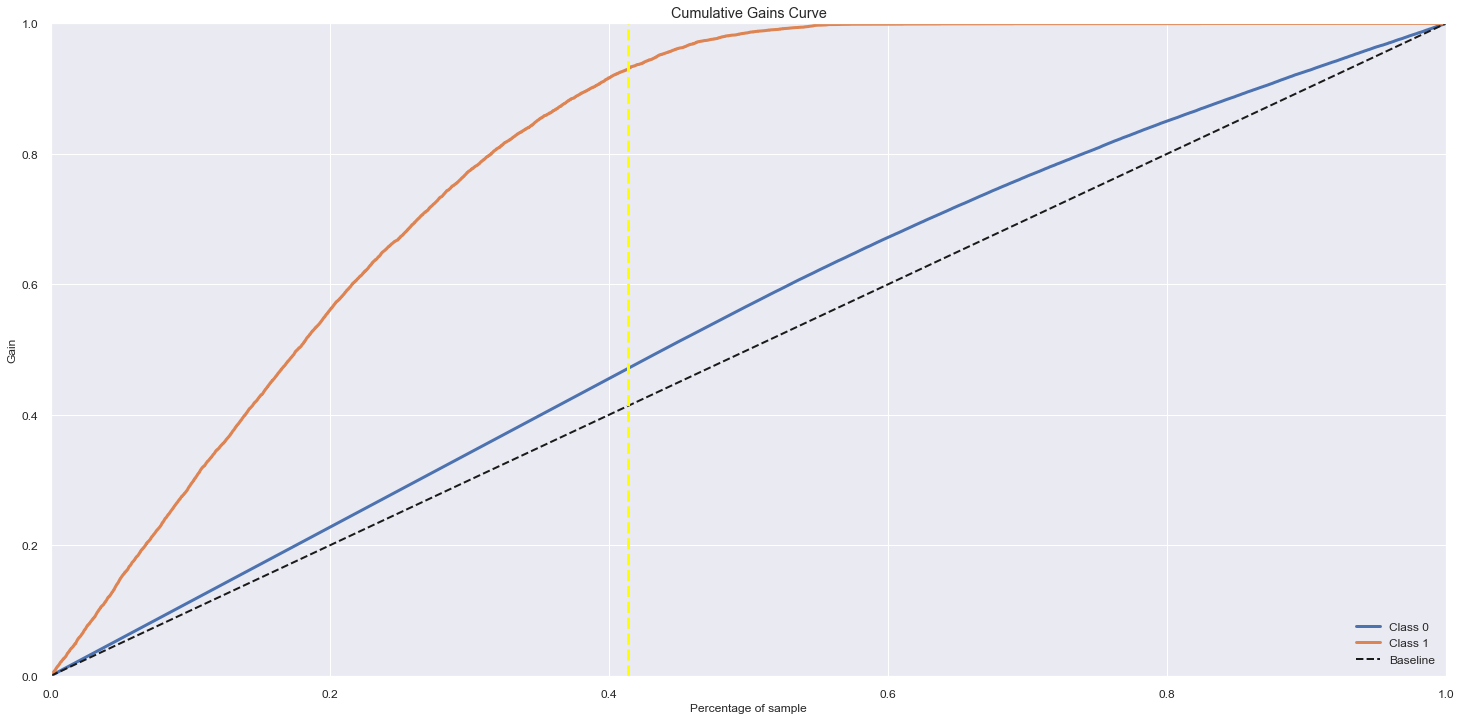

In [93]:
# skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lgbm)
plt.axvline(0.4138, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

 By Making 20 thousand calls, the model proposed is roughly 2,7 times better than random choice.

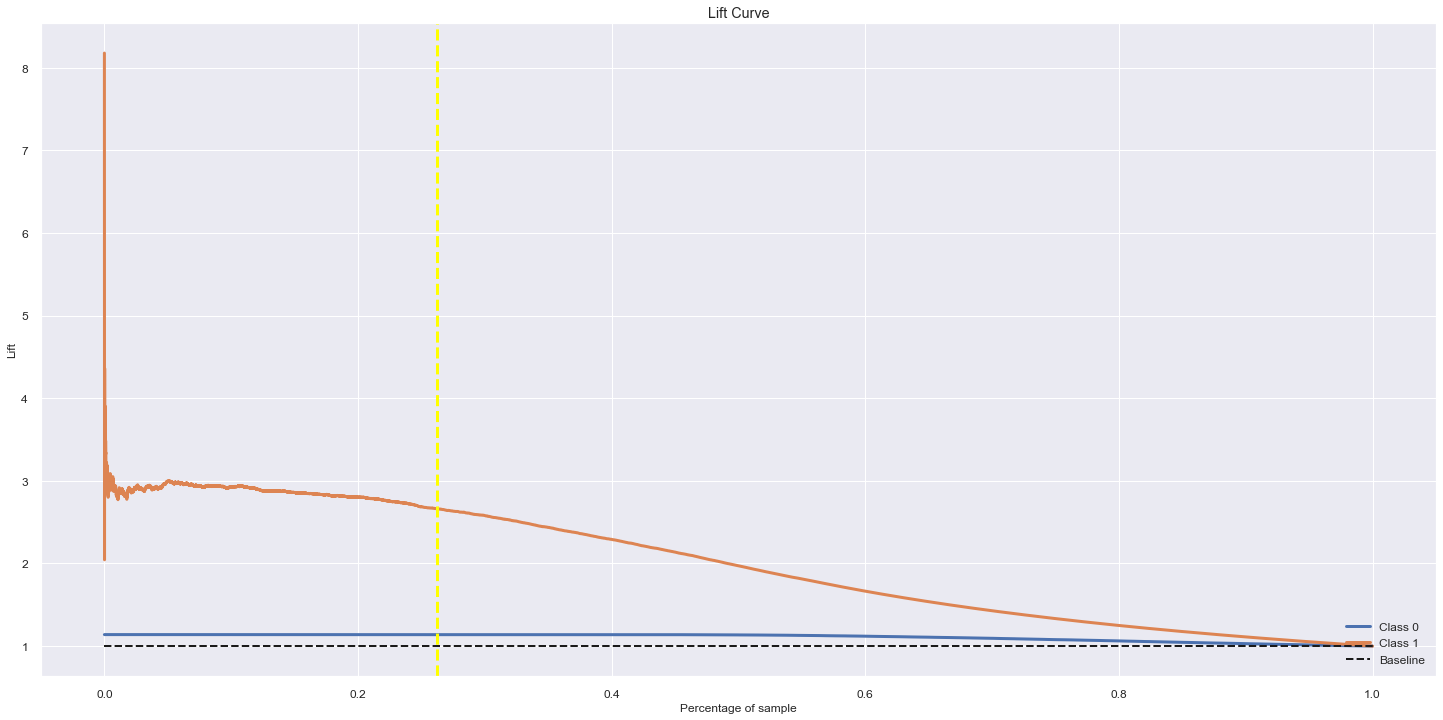

In [97]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lgbm)
plt.axvline(0.2623, 0, 1, color='yellow', ls='--', lw=3);

 Baseline model would predict 26% of all people interested in insurance by making 20 thousand calls, whereas, our model, would predict 62.65%. If each insurance is 1000 this represents a diference of 29,60 million dollars in 20 thousand calls

In [123]:
random_choice = (26/100) * len(data)
model         = (68/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

19828120 revenue with random choice
51858160 revenue with model
difference in $: 32030040


With 26 thousand calls and 4 hundred, our model would predict 80% of all people interested, and the difference from baseline would rise to 35,7 million dollar

In [124]:
random_choice = (33/100) * len(data)
model         = (81/100) * len(data)

x = random_choice * 1000
y = model * 1000

print(str(int(x)) + ' revenue with random choice')
print(str(int(y)) + ' revenue with model')

print('difference in $: ' + str(int(y-x)) )

25166460 revenue with random choice
61772220 revenue with model
difference in $: 36605760


# 11.0 Test in outside data

In [128]:
df_test= future_test.copy()

In [142]:

# Vehicle Damage Number
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df_test['vehicle_age'] =  df_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

annual_premium_scaler       =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/annual_premium_scaler.pkl','rb' ) )
age_scaler                  =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/age_scaler.pkl','rb' ) ) 
vintage_scaler              =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/vintage_scaler.pkl','rb' ) ) 
target_encode_gender_scaler =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_gender_scaler.pkl','rb' ) )
target_encode_region_scaler =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_region_scaler.pkl','rb' ) )
target_encode_policy_sales_channel_scaler =   pickle.load( open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_policy_sales_channel_scaler.pkl','rb' ) )


# anual premium - StandarScaler
df_test['annual_premium'] = annual_premium_scaler.transform( df_test[['annual_premium']].values )

# Age - MinMaxScaler
df_test['age'] = age_scaler.transform( df_test[['age']].values )

# Vintage - MinMaxScaler
df_test['vintage'] = vintage_scaler.transform( df_test[['vintage']].values )

# gender - One Hot Encoding / Target Encoding
df_test.loc[:, 'gender'] = df_test['gender'].map( target_encode_gender_scaler )

# region_code -g
df_test= target_encode_region_scaler.transform( df_test )

# vehicle_age - One Hot Encoding / Frequency Encoding
df_test = pd.get_dummies( df_test, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel -
df_test= target_encode_policy_sales_channel_scaler.transform( df_test )

df_test.drop(columns = [ 'policy_sales_channel', 'region_code', 'id'], inplace = True)

columns_order = ['gender', 
                 'age', 
                 'driving_license', 
                 'previously_insured',
                 'vehicle_damage', 
                 'annual_premium', 
                 'vintage',
                 'vehicle_age_below_1_year',
                 'vehicle_age_between_1_2_year',
                 'vehicle_age_over_2_years',
                 'region_code_Kfold_Target_Enc',
                 'policy_sales_channel_Kfold_Target_Enc', 
                 'response']

#keeping response as the last column for better slicing
df_test = df_test.reindex(columns = columns_order)

x_df_test = df_test.iloc[:, :-1]
y_df_test = df_test.iloc[:, -1:]

KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, region_code_Kfold_Target_Enc and, response is 0.14156509793630725.
KFold(n_splits=5, random_state=2021, shuffle=True)
Correlation between the new feature, policy_sales_channel_Kfold_Target_Enc and, response is 0.2631699829357781.


In [147]:
 pred = model_lgbm.predict_proba( x_df_test )
    

0.262977962446747
0.6513722126929674


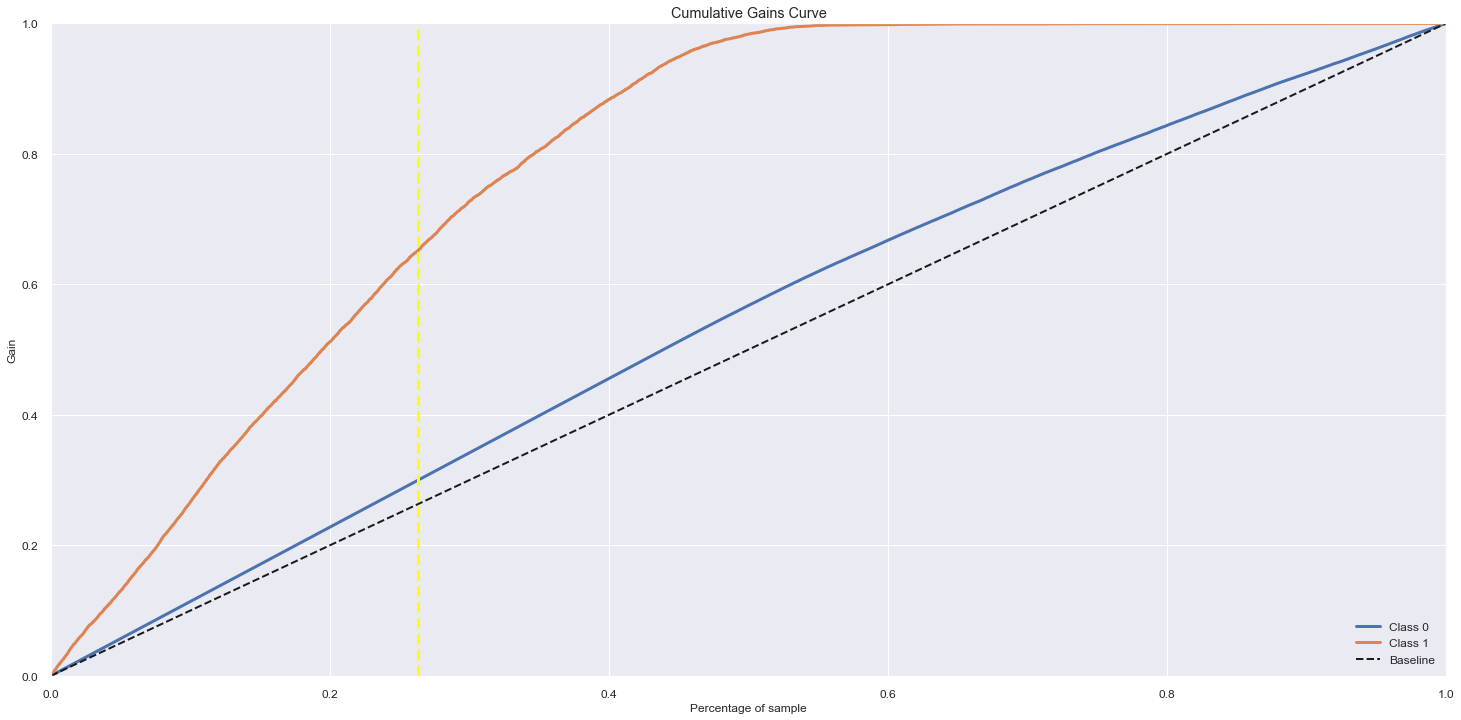

In [148]:
data = x_df_test.copy()

data['response'] = y_df_test.copy()
data['score'] = pred[:, 1].tolist()
data = data.sort_values('score', ascending=False)

percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)

print(percent_of_dataset)
print(recall_at_20000)

#skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_df_test, pred)
plt.axvline(0.2629, 0, 1, color='yellow', ls='--', lw=3)
plt.show();

0.33003734287066744
0.7734777015437393


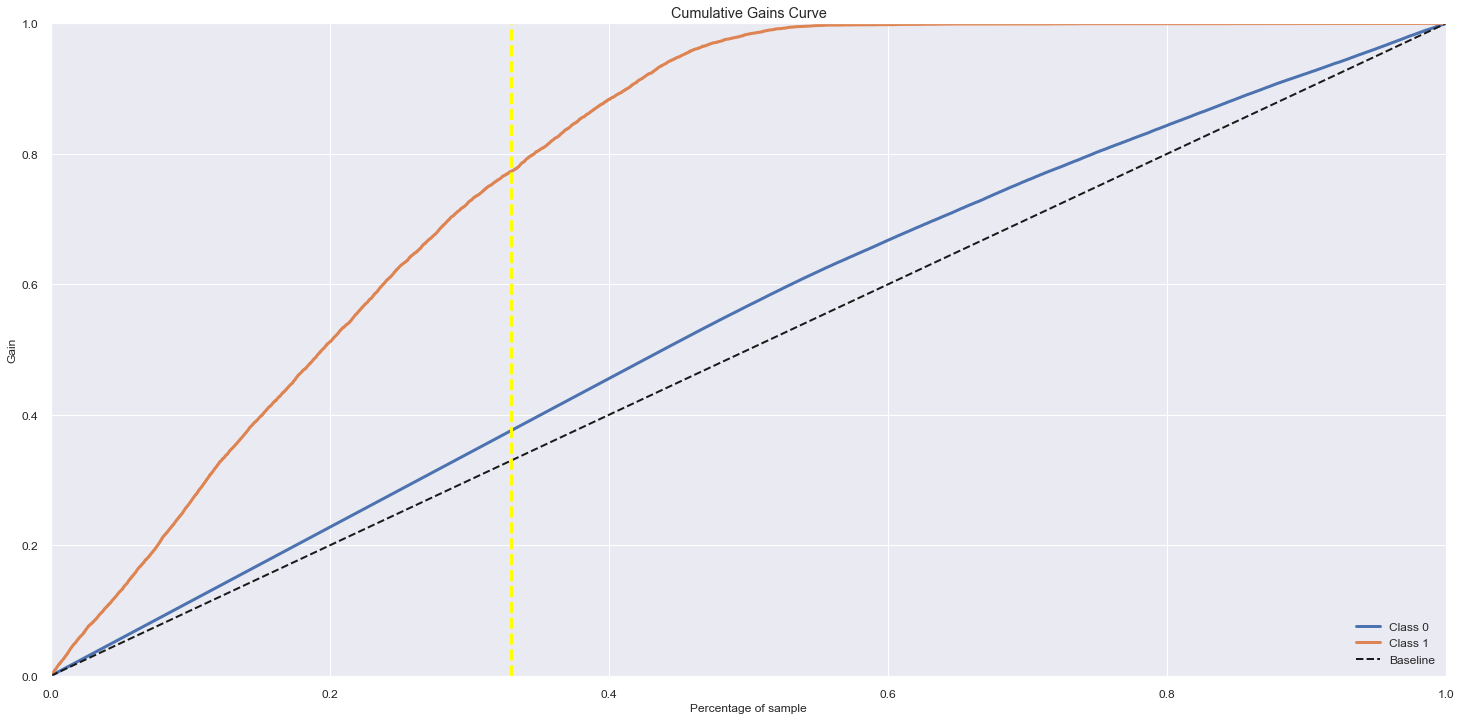

In [149]:
percent_of_dataset = 25100 / len(data)
recall_at_25100 = recall_at_k(data, k = 25100)

print(percent_of_dataset)
print(recall_at_25100)

# skplt.metrics.plot_cumulative_gain(y_test, yhat_nb)
skplt.metrics.plot_cumulative_gain(y_df_test, pred)
plt.axvline(0.33, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

# 12.0. Deploy to Production

In [ ]:
# Save trained model
pickle.dump( et, open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_health_insurance.pkl',  ) )
# pickle.dump( lr_model, open( '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_linear_regression.pkl', 'wb' ) )

## 12.1 Health Insurance Class

In [106]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path = '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        # rename 
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender )

        # region_code - Target Encoding / Frequency Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 12.2 API Handler

In [111]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# loading model
path = '/home/luke/repos/pa004_health_insurance_cross_sell/health_insurance_cross-sell/'
model = pickle.load( open( path + 'src/models/model_health_insurance.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/heathinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

KeyboardInterrupt: 

## 12.3 API Tester

In [281]:
import requests

In [282]:
# loading test dataset
df_test = x_validation
df_test['response'] = y_validation

In [283]:
df_test = df_test.sample(10)

In [284]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [285]:
data

'[{"id": 74147, "gender": "Female", "age": 26, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 43343.0, "policy_sales_channel": 124.0, "vintage": 288, "response": 0}, {"id": 322299, "gender": "Male", "age": 44, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 45209.0, "policy_sales_channel": 124.0, "vintage": 230, "response": 0}, {"id": 331804, "gender": "Female", "age": 43, "driving_license": 1, "region_code": 15.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 26894.0, "policy_sales_channel": 26.0, "vintage": 171, "response": 0}, {"id": 363080, "gender": "Male", "age": 44, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "annual_premium": 41405.0, "policy_sales_channel": 23.

In [286]:
# API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [287]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
3,363080,0.138780,0.369231,1,0.187988,0,below_1_year,0,0.492486,23.0,0.930796,0,0.050289
7,318230,0.138780,0.230769,1,0.187988,0,below_1_year,0,-0.511883,26.0,0.615917,0,0.044430
0,74147,0.099756,0.092308,1,0.187988,0,below_1_year,0,0.669245,124.0,0.961938,0,0.044017
1,322299,0.138780,0.369231,1,0.187988,0,below_1_year,0,0.839437,124.0,0.761246,0,0.041979
9,107812,0.138780,0.338462,1,0.187988,0,below_1_year,0,3.605010,26.0,0.640138,1,0.037594
